In [190]:
%load_ext autoreload
%autoreload 2
import networkx as nx  
import matplotlib.pyplot as plt
import operator
import numpy as np
import numpy
import sys
import json
import pdb
from sklearn.model_selection import train_test_split
import random
import sys
import pickle
import numpy as np
import random
np.set_printoptions(threshold=sys.maxsize)
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from torch.autograd import Variable
from read_graph import read_graphs_in_networkx,save_graphs_nx
from utils import calculate_M,graphs_db,encode_M_matrix,decode_M_matrix
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_file = "../data/yeast.txt"
(graphs,node_dict,edge_dict,node_label_freq_dict,edge_label_freq_dict) = read_graphs_in_networkx(data_file,True,100000)
print("Number of graphs loaded " , len(graphs))

(train_graphs,val_graphs) = train_test_split(graphs,test_size=0.2, random_state=42)
(train_graphs,test_graphs) = train_test_split(train_graphs,test_size=0.3, random_state=42)

Number of graphs loaded  64110


15387

In [149]:
model_save_path = "../models/"

In [128]:
len_node_labels = len(node_dict)+1
len_edge_labels = len(edge_dict)+1
weight_vector_node_label = np.ones(len_node_labels)
weight_vector_edge_label = np.ones(len_edge_labels)

node_max_value= max(node_label_freq_dict.items(), key=operator.itemgetter(1))[1]


for label, count in node_label_freq_dict.items():
    weight_vector_node_label[label] = min(4,node_max_value /count)

weight_vector_node_label[0]=1
edge_count_max_value= max(edge_label_freq_dict.items(), key=operator.itemgetter(1))[1]
most_frequent_edge_label = max(edge_label_freq_dict.items(), key=operator.itemgetter(1))[0]
print(most_frequent_edge_label)

for label, count in edge_label_freq_dict.items():
    weight_vector_edge_label[label] = min(4,edge_count_max_value /count)
weight_vector_edge_label[0] = 1
print(weight_vector_node_label,weight_vector_edge_label)
print(edge_label_freq_dict,node_label_freq_dict)

[1.         4.         4.         4.         1.06481741 1.
 4.         4.         4.         4.         4.         4.        ] [1. 4. 1. 4.]
{1: 405320, 2: 1992297, 3: 5443} {1: 19950, 2: 170441, 3: 122215, 4: 955268, 5: 1017186, 6: 17022, 7: 8423, 8: 1671, 9: 3714, 10: 340, 11: 556}


2


In [5]:
max_num_edges = max([graph.number_of_edges() for graph in graphs])
min_num_edges = min([graph.number_of_edges() for graph in graphs])
max_num_nodes = max([graph.number_of_nodes() for graph in graphs])
min_num_nodes = min([graph.number_of_nodes() for graph in graphs])
M = int(calculate_M(graphs,len(graphs)))
print("Number of training graphs, max nodes, min nodes , max edges , min edges , max prev nodes", len(train_graphs), max_num_nodes, min_num_nodes, max_num_edges, min_num_edges,M)
mean_number_of_edges = np.mean([graph.number_of_edges() for graph in graphs])
std_number_of_edges = np.std([graph.number_of_edges() for graph in graphs])
mean_number_of_nodes = np.mean([graph.number_of_nodes() for graph in graphs])
std_number_of_nodes = np.std([graph.number_of_nodes() for graph in graphs])
print(mean_number_of_edges,std_number_of_edges,mean_number_of_nodes,std_number_of_nodes)

Number of training graphs, max nodes, min nodes , max edges , min edges , max prev nodes 35901 129 5 135 4 16


37.483387927000464 13.937685710095366 36.13766963032288 13.074459455805433


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

In [ ]:
for batch_ndx, sample in enumerate(graph_loader):
    print(batch_ndx)
    break

### Training code ###

In [ ]:
        
graph_db = graphs_db(train_graphs,max_num_nodes,M)
(a, b,c,d) = graph_db.__getitem__(10)
graph_loader = DataLoader(graph_db,batch_size= 16,num_workers=2,shuffle=True)

In [129]:

        
graph_db = graphs_db(train_graphs,max_num_nodes,M)
(a, b,c,d) = graph_db.__getitem__(10)
graph_loader = DataLoader(graph_db,batch_size= 32,num_workers=2,shuffle=True)


class CUSTOM_RNN_NODE(torch.nn.Module):
    def __init__(self, input_size, embedding_size=64, hidden_size=32,output_size =None,number_layers=4,name="",len_unique_node_labels=None,len_unique_edge_labels=None):
        super(CUSTOM_RNN_NODE, self).__init__()
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.number_layers = number_layers
        self.name = name
        self.len_unique_node_labels = len_unique_node_labels
        self.len_unique_edge_labels = len_unique_edge_labels
        
        self.sequence_embedding_size = embedding_size*input_size + embedding_size*4
        self.input = nn.Embedding(self.len_unique_edge_labels, embedding_size)
        self.input2 = nn.Embedding(self.len_unique_node_labels, embedding_size*4)
        self.rnn = nn.GRU(input_size=self.sequence_embedding_size,hidden_size = self.hidden_size,
                                num_layers=self.number_layers,bias=True,batch_first=True,dropout=0)
        self.hidden_n = None
        #self.out = nn.Sequential(nn.Linear(self.hidden_size,self.embedding_size),nn.ReLU(),nn.Linear(self.embedding_size,self.output_size))
        self.out = nn.Sequential(nn.Linear(self.hidden_size,self.sequence_embedding_size),nn.ReLU(),nn.Linear(self.sequence_embedding_size,self.output_size))
        self.relu = nn.ReLU()
        
        ###MLP for loss
        self.Linear = nn.Sequential(nn.ReLU(),nn.Linear(self.output_size,self.len_unique_node_labels))
    def forward(self,input,x_node_label, seq_lengths = None,is_packed=True,is_MLP=False):
        
        input = self.input(input)
        input = self.relu(input)
        input = input.reshape(input.shape[0],input.shape[1],-1)
        input2 = self.input2(x_node_label)
        input_concat =torch.cat((input, input2), 2)
        if is_packed:
            input_concat = pack_padded_sequence(input_concat,seq_lengths,batch_first=True,enforce_sorted=False)
        output,self.hidden_n = self.rnn(input_concat,self.hidden_n)
        
        if is_packed:
            output = pad_packed_sequence(output,batch_first=True)[0]
        output = self.out(output)
        if not is_MLP:
            return output
        
        mlp_output= self.Linear(output)
        return output,mlp_output
        
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.number_layers, batch_size, self.hidden_size))
    
class CUSTOM_RNN_EDGE(torch.nn.Module):
    def __init__(self, input_size, embedding_size=64, hidden_size=32,output_size =None,number_layers=4,name="",len_unique_edge_labels=None):
        super(CUSTOM_RNN_EDGE, self).__init__()
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.number_layers = number_layers
        self.name = name
        self.len_unique_edge_labels = len_unique_edge_labels
        
        self.embedding= nn.Embedding(self.len_unique_edge_labels,embedding_size)
        self.linear = nn.Linear(self.input_size,self.embedding_size)
        self.rnn = nn.GRU(input_size=self.embedding_size,hidden_size = self.hidden_size,
                                num_layers=self.number_layers,bias=True,batch_first=True,dropout=0)
        self.hidden_n = None
        self.out = nn.Sequential(nn.Linear(self.hidden_size,self.embedding_size),nn.ReLU(),nn.Linear(self.embedding_size,self.output_size))
        
        self.relu = nn.ReLU()
        self.Linear_mlp = nn.Sequential(nn.ReLU(),nn.Linear(self.output_size,self.len_unique_edge_labels))
    def forward(self,input, seq_lengths = None,is_mlp=False):
        #print("doing forward loop for rnn ," ,self.name)
        input = self.embedding(input)
        input = self.relu(input)
        input = input.reshape(input.size(0),input.size(1),-1)
        output,self.hidden_n = self.rnn(input,self.hidden_n)
        output = self.out(output)
        
        if not is_mlp:
            return output
        output_mlp = self.Linear_mlp(output)
        return output,output_mlp

        
### Define two RNNs 1 for graph level and 2nd for edge level 
hidden_size_node_rnn = 128
hidden_size_edge_rnn = 32
embedding_size_node_rnn = 64
embedding_size_edge_rnn = 16
num_layers = 4
node_rnn = CUSTOM_RNN_NODE(input_size=M, embedding_size=embedding_size_node_rnn,
                hidden_size=hidden_size_node_rnn, number_layers=num_layers,output_size=len_node_labels,
            name="node",len_unique_node_labels=len_node_labels,len_unique_edge_labels=len_edge_labels)
edge_rnn = CUSTOM_RNN_EDGE(input_size=1, embedding_size=embedding_size_edge_rnn,
                   hidden_size=len_node_labels, number_layers=num_layers, output_size=len_edge_labels,
                    name="edge",len_unique_edge_labels=len_edge_labels)

lr = 0.001
optimizer_node = optim.Adam(list(node_rnn.parameters()), lr=lr)
optimizer_edge = optim.Adam(list(edge_rnn.parameters()),lr=lr)



In [205]:

epochs = 10
for epoch in range(0,epochs):
    print("####Epoch#### ", epoch)
    node_rnn.train()
    edge_rnn.train()
    loss = 0
    for ndx, data in enumerate(graph_loader):
        node_rnn.zero_grad()
        edge_rnn.zero_grad()
        
        max_seq_len = max(data[2])
        node_labels = data[3].long()
        node_rnn.hidden_n = node_rnn.init_hidden(batch_size=list(data[0].size())[0]) 
        x = data[0].float()[:,0:max_seq_len,:].long()
        x[:,0] = x[:,0]*most_frequent_edge_label
        y = data[1].float()[:,0:max_seq_len,:].long()
        
        y_node_labels = node_labels.data.clone()
        node_labels = node_labels[:,0:max_seq_len]
        y_node_labels[:,0:-1] = y_node_labels[:,1:]
        y_node_labels[:,-1] = 0
        y_node_labels = y_node_labels[:,0:max_seq_len]
        h = node_rnn(x,node_labels, seq_lengths=data[2])
        h_ce = h.view(-1,h.size(2))
        h = pack_padded_sequence(h,data[2],batch_first=True,enforce_sorted=False).data
        
        #criterion = F.cross_entropy(weight=torch.FloatTensor(weight_vector_node_label))
        #criterion = nn.CrossEntropyLoss()
        #y_node_labels = pack_padded_sequence(y_node_labels,data[2],batch_first=True,enforce_sorted=False).data
        y_node_labels = y_node_labels.reshape(-1)
        loss_node_label = F.cross_entropy(input=h_ce,target=y_node_labels,weight=torch.Tensor(weight_vector_node_label) ) #weight=torch.Tensor(weight_vector_node_label)
        #print(max_seq_len,loss_node_label)
        
        
  
#         ## initialized edge rnn with node rnn hiddent state
        h_edge_tmp = torch.zeros(num_layers-1, h.size(0), h.size(1))
        edge_rnn.hidden_n = torch.cat((h.view(1,h.size(0),h.size(1)),h_edge_tmp),dim=0)
        y_packed = pack_padded_sequence(y,data[2],batch_first=True,enforce_sorted=False).data
        edge_rnn_y = y_packed.view(y_packed.size(0),y_packed.size(1),1)
        edge_rnn_x = torch.cat((torch.ones(edge_rnn_y.size(0),1,1).long()*most_frequent_edge_label,edge_rnn_y[:,0:-1,0:1]),dim=1)
        
        
        edge_rnn_y_pred = edge_rnn(edge_rnn_x)
        #print(edge_rnn_y_pred.size())
        
        
#         output_y_len = []
#         output_y_len_bin = np.bincount(np.array(data[2]))
#         for i in range(len(output_y_len_bin)-1,0,-1):
#             count_temp = np.sum(output_y_len_bin[i:]) # count how many y_len is above i
#             output_y_len.extend([min(i,y.size(2))]*count_temp)
#         print(output_y_len)
        #edge_rnn_y_pred = pack_padded_sequence(edge_rnn_y_pred,data[2],enforce_sorted=False).data
        #edge_rnn_y = pack_padded_sequence(edge_rnn_y,data[2],enforce_sorted=False).data.reshape(-1)
        #print(edge_rnn_y_pred.size(),edge_rnn_y.size())
        
        #edge_rnn_y_pred = F.sigmoid(edge_rnn_y_pred)
        edge_rnn_y = edge_rnn_y.reshape(-1)
        edge_rnn_y_pred = edge_rnn_y_pred.view(-1,edge_rnn_y_pred.size(2))
        loss_edge_label = F.cross_entropy(edge_rnn_y_pred, edge_rnn_y,weight=torch.Tensor(weight_vector_edge_label))
        #print(loss_edge_label)
        
        total_loss = loss_edge_label+loss_node_label
        total_loss.backward()
        optimizer_edge.step()
        optimizer_node.step()
        print(ndx,total_loss,loss_edge_label,loss_node_label)

        #print(h.size())

        
        #break

####Epoch####  0
0 tensor(1.0567, grad_fn=<AddBackward0>) tensor(0.1044, grad_fn=<NllLossBackward>) tensor(0.9523, grad_fn=<NllLossBackward>)
1 tensor(1.1580, grad_fn=<AddBackward0>) tensor(0.1216, grad_fn=<NllLossBackward>) tensor(1.0364, grad_fn=<NllLossBackward>)
2 tensor(0.9408, grad_fn=<AddBackward0>) tensor(0.1119, grad_fn=<NllLossBackward>) tensor(0.8289, grad_fn=<NllLossBackward>)
3 tensor(1.0449, grad_fn=<AddBackward0>) tensor(0.1111, grad_fn=<NllLossBackward>) tensor(0.9338, grad_fn=<NllLossBackward>)
4 tensor(0.8101, grad_fn=<AddBackward0>) tensor(0.1004, grad_fn=<NllLossBackward>) tensor(0.7097, grad_fn=<NllLossBackward>)
5 tensor(1.0730, grad_fn=<AddBackward0>) tensor(0.1091, grad_fn=<NllLossBackward>) tensor(0.9640, grad_fn=<NllLossBackward>)
6 tensor(0.9572, grad_fn=<AddBackward0>) tensor(0.1100, grad_fn=<NllLossBackward>) tensor(0.8472, grad_fn=<NllLossBackward>)
7 tensor(0.9277, grad_fn=<AddBackward0>) tensor(0.1059, grad_fn=<NllLossBackward>) tensor(0.8217, grad_fn=<N

65 tensor(0.9976, grad_fn=<AddBackward0>) tensor(0.1142, grad_fn=<NllLossBackward>) tensor(0.8834, grad_fn=<NllLossBackward>)
66 tensor(0.9218, grad_fn=<AddBackward0>) tensor(0.1043, grad_fn=<NllLossBackward>) tensor(0.8175, grad_fn=<NllLossBackward>)
67 tensor(0.8369, grad_fn=<AddBackward0>) tensor(0.1016, grad_fn=<NllLossBackward>) tensor(0.7353, grad_fn=<NllLossBackward>)
68 tensor(1.1635, grad_fn=<AddBackward0>) tensor(0.1107, grad_fn=<NllLossBackward>) tensor(1.0528, grad_fn=<NllLossBackward>)
69 tensor(0.9755, grad_fn=<AddBackward0>) tensor(0.1063, grad_fn=<NllLossBackward>) tensor(0.8692, grad_fn=<NllLossBackward>)
70 tensor(1.0971, grad_fn=<AddBackward0>) tensor(0.1092, grad_fn=<NllLossBackward>) tensor(0.9880, grad_fn=<NllLossBackward>)
71 tensor(0.8514, grad_fn=<AddBackward0>) tensor(0.1106, grad_fn=<NllLossBackward>) tensor(0.7407, grad_fn=<NllLossBackward>)
72 tensor(1.0297, grad_fn=<AddBackward0>) tensor(0.1188, grad_fn=<NllLossBackward>) tensor(0.9110, grad_fn=<NllLossBac

130 tensor(0.9420, grad_fn=<AddBackward0>) tensor(0.1091, grad_fn=<NllLossBackward>) tensor(0.8329, grad_fn=<NllLossBackward>)
131 tensor(1.1458, grad_fn=<AddBackward0>) tensor(0.1063, grad_fn=<NllLossBackward>) tensor(1.0395, grad_fn=<NllLossBackward>)
132 tensor(0.9182, grad_fn=<AddBackward0>) tensor(0.1203, grad_fn=<NllLossBackward>) tensor(0.7979, grad_fn=<NllLossBackward>)
133 tensor(0.8636, grad_fn=<AddBackward0>) tensor(0.1119, grad_fn=<NllLossBackward>) tensor(0.7516, grad_fn=<NllLossBackward>)
134 tensor(0.9965, grad_fn=<AddBackward0>) tensor(0.1103, grad_fn=<NllLossBackward>) tensor(0.8862, grad_fn=<NllLossBackward>)
135 tensor(0.8507, grad_fn=<AddBackward0>) tensor(0.1242, grad_fn=<NllLossBackward>) tensor(0.7265, grad_fn=<NllLossBackward>)
136 tensor(0.9053, grad_fn=<AddBackward0>) tensor(0.1126, grad_fn=<NllLossBackward>) tensor(0.7927, grad_fn=<NllLossBackward>)
137 tensor(1.1084, grad_fn=<AddBackward0>) tensor(0.1051, grad_fn=<NllLossBackward>) tensor(1.0033, grad_fn=<Nl

195 tensor(0.9002, grad_fn=<AddBackward0>) tensor(0.1044, grad_fn=<NllLossBackward>) tensor(0.7958, grad_fn=<NllLossBackward>)
196 tensor(0.7861, grad_fn=<AddBackward0>) tensor(0.1076, grad_fn=<NllLossBackward>) tensor(0.6785, grad_fn=<NllLossBackward>)
197 tensor(0.8014, grad_fn=<AddBackward0>) tensor(0.1040, grad_fn=<NllLossBackward>) tensor(0.6974, grad_fn=<NllLossBackward>)
198 tensor(0.9899, grad_fn=<AddBackward0>) tensor(0.1058, grad_fn=<NllLossBackward>) tensor(0.8841, grad_fn=<NllLossBackward>)
199 tensor(0.8784, grad_fn=<AddBackward0>) tensor(0.1165, grad_fn=<NllLossBackward>) tensor(0.7619, grad_fn=<NllLossBackward>)
200 tensor(0.9058, grad_fn=<AddBackward0>) tensor(0.1010, grad_fn=<NllLossBackward>) tensor(0.8048, grad_fn=<NllLossBackward>)
201 tensor(1.1532, grad_fn=<AddBackward0>) tensor(0.1016, grad_fn=<NllLossBackward>) tensor(1.0516, grad_fn=<NllLossBackward>)
202 tensor(0.8768, grad_fn=<AddBackward0>) tensor(0.0989, grad_fn=<NllLossBackward>) tensor(0.7779, grad_fn=<Nl

260 tensor(1.0455, grad_fn=<AddBackward0>) tensor(0.1113, grad_fn=<NllLossBackward>) tensor(0.9343, grad_fn=<NllLossBackward>)
261 tensor(0.8195, grad_fn=<AddBackward0>) tensor(0.0924, grad_fn=<NllLossBackward>) tensor(0.7271, grad_fn=<NllLossBackward>)
262 tensor(1.0939, grad_fn=<AddBackward0>) tensor(0.1056, grad_fn=<NllLossBackward>) tensor(0.9883, grad_fn=<NllLossBackward>)
263 tensor(1.0501, grad_fn=<AddBackward0>) tensor(0.1117, grad_fn=<NllLossBackward>) tensor(0.9384, grad_fn=<NllLossBackward>)
264 tensor(0.9122, grad_fn=<AddBackward0>) tensor(0.1054, grad_fn=<NllLossBackward>) tensor(0.8068, grad_fn=<NllLossBackward>)
265 tensor(0.7719, grad_fn=<AddBackward0>) tensor(0.1019, grad_fn=<NllLossBackward>) tensor(0.6701, grad_fn=<NllLossBackward>)
266 tensor(1.0272, grad_fn=<AddBackward0>) tensor(0.1165, grad_fn=<NllLossBackward>) tensor(0.9107, grad_fn=<NllLossBackward>)
267 tensor(1.0566, grad_fn=<AddBackward0>) tensor(0.1109, grad_fn=<NllLossBackward>) tensor(0.9457, grad_fn=<Nl

325 tensor(1.0074, grad_fn=<AddBackward0>) tensor(0.1046, grad_fn=<NllLossBackward>) tensor(0.9028, grad_fn=<NllLossBackward>)
326 tensor(0.9767, grad_fn=<AddBackward0>) tensor(0.1087, grad_fn=<NllLossBackward>) tensor(0.8680, grad_fn=<NllLossBackward>)
327 tensor(0.9886, grad_fn=<AddBackward0>) tensor(0.0947, grad_fn=<NllLossBackward>) tensor(0.8939, grad_fn=<NllLossBackward>)
328 tensor(0.9180, grad_fn=<AddBackward0>) tensor(0.1032, grad_fn=<NllLossBackward>) tensor(0.8148, grad_fn=<NllLossBackward>)
329 tensor(0.9868, grad_fn=<AddBackward0>) tensor(0.1055, grad_fn=<NllLossBackward>) tensor(0.8814, grad_fn=<NllLossBackward>)
330 tensor(1.0565, grad_fn=<AddBackward0>) tensor(0.1092, grad_fn=<NllLossBackward>) tensor(0.9473, grad_fn=<NllLossBackward>)
331 tensor(0.8939, grad_fn=<AddBackward0>) tensor(0.1039, grad_fn=<NllLossBackward>) tensor(0.7900, grad_fn=<NllLossBackward>)
332 tensor(0.9726, grad_fn=<AddBackward0>) tensor(0.1190, grad_fn=<NllLossBackward>) tensor(0.8536, grad_fn=<Nl

390 tensor(1.0990, grad_fn=<AddBackward0>) tensor(0.1055, grad_fn=<NllLossBackward>) tensor(0.9935, grad_fn=<NllLossBackward>)
391 tensor(0.9387, grad_fn=<AddBackward0>) tensor(0.1071, grad_fn=<NllLossBackward>) tensor(0.8316, grad_fn=<NllLossBackward>)
392 tensor(0.8078, grad_fn=<AddBackward0>) tensor(0.1111, grad_fn=<NllLossBackward>) tensor(0.6967, grad_fn=<NllLossBackward>)
393 tensor(1.0729, grad_fn=<AddBackward0>) tensor(0.1039, grad_fn=<NllLossBackward>) tensor(0.9690, grad_fn=<NllLossBackward>)
394 tensor(1.0860, grad_fn=<AddBackward0>) tensor(0.1055, grad_fn=<NllLossBackward>) tensor(0.9805, grad_fn=<NllLossBackward>)
395 tensor(0.8965, grad_fn=<AddBackward0>) tensor(0.0990, grad_fn=<NllLossBackward>) tensor(0.7976, grad_fn=<NllLossBackward>)
396 tensor(0.9058, grad_fn=<AddBackward0>) tensor(0.1183, grad_fn=<NllLossBackward>) tensor(0.7875, grad_fn=<NllLossBackward>)
397 tensor(0.9689, grad_fn=<AddBackward0>) tensor(0.1116, grad_fn=<NllLossBackward>) tensor(0.8574, grad_fn=<Nl

455 tensor(0.9108, grad_fn=<AddBackward0>) tensor(0.1048, grad_fn=<NllLossBackward>) tensor(0.8060, grad_fn=<NllLossBackward>)
456 tensor(0.8652, grad_fn=<AddBackward0>) tensor(0.0934, grad_fn=<NllLossBackward>) tensor(0.7718, grad_fn=<NllLossBackward>)
457 tensor(0.9851, grad_fn=<AddBackward0>) tensor(0.1114, grad_fn=<NllLossBackward>) tensor(0.8737, grad_fn=<NllLossBackward>)
458 tensor(0.9999, grad_fn=<AddBackward0>) tensor(0.1041, grad_fn=<NllLossBackward>) tensor(0.8958, grad_fn=<NllLossBackward>)
459 tensor(1.0596, grad_fn=<AddBackward0>) tensor(0.1071, grad_fn=<NllLossBackward>) tensor(0.9524, grad_fn=<NllLossBackward>)
460 tensor(0.8826, grad_fn=<AddBackward0>) tensor(0.0910, grad_fn=<NllLossBackward>) tensor(0.7916, grad_fn=<NllLossBackward>)
461 tensor(0.9326, grad_fn=<AddBackward0>) tensor(0.0989, grad_fn=<NllLossBackward>) tensor(0.8337, grad_fn=<NllLossBackward>)
462 tensor(1.0609, grad_fn=<AddBackward0>) tensor(0.1139, grad_fn=<NllLossBackward>) tensor(0.9470, grad_fn=<Nl

520 tensor(0.8929, grad_fn=<AddBackward0>) tensor(0.1126, grad_fn=<NllLossBackward>) tensor(0.7803, grad_fn=<NllLossBackward>)
521 tensor(1.0343, grad_fn=<AddBackward0>) tensor(0.1042, grad_fn=<NllLossBackward>) tensor(0.9301, grad_fn=<NllLossBackward>)
522 tensor(1.0413, grad_fn=<AddBackward0>) tensor(0.1101, grad_fn=<NllLossBackward>) tensor(0.9312, grad_fn=<NllLossBackward>)
523 tensor(1.0068, grad_fn=<AddBackward0>) tensor(0.1098, grad_fn=<NllLossBackward>) tensor(0.8971, grad_fn=<NllLossBackward>)
524 tensor(1.0217, grad_fn=<AddBackward0>) tensor(0.1131, grad_fn=<NllLossBackward>) tensor(0.9086, grad_fn=<NllLossBackward>)
525 tensor(0.9810, grad_fn=<AddBackward0>) tensor(0.0964, grad_fn=<NllLossBackward>) tensor(0.8846, grad_fn=<NllLossBackward>)
526 tensor(0.9863, grad_fn=<AddBackward0>) tensor(0.1205, grad_fn=<NllLossBackward>) tensor(0.8658, grad_fn=<NllLossBackward>)
527 tensor(0.7457, grad_fn=<AddBackward0>) tensor(0.1041, grad_fn=<NllLossBackward>) tensor(0.6415, grad_fn=<Nl

585 tensor(0.9474, grad_fn=<AddBackward0>) tensor(0.1098, grad_fn=<NllLossBackward>) tensor(0.8375, grad_fn=<NllLossBackward>)
586 tensor(0.8370, grad_fn=<AddBackward0>) tensor(0.1043, grad_fn=<NllLossBackward>) tensor(0.7327, grad_fn=<NllLossBackward>)
587 tensor(0.7621, grad_fn=<AddBackward0>) tensor(0.1143, grad_fn=<NllLossBackward>) tensor(0.6477, grad_fn=<NllLossBackward>)
588 tensor(0.9429, grad_fn=<AddBackward0>) tensor(0.1008, grad_fn=<NllLossBackward>) tensor(0.8421, grad_fn=<NllLossBackward>)
589 tensor(0.9032, grad_fn=<AddBackward0>) tensor(0.1030, grad_fn=<NllLossBackward>) tensor(0.8002, grad_fn=<NllLossBackward>)
590 tensor(0.7964, grad_fn=<AddBackward0>) tensor(0.1097, grad_fn=<NllLossBackward>) tensor(0.6867, grad_fn=<NllLossBackward>)
591 tensor(0.9683, grad_fn=<AddBackward0>) tensor(0.0983, grad_fn=<NllLossBackward>) tensor(0.8701, grad_fn=<NllLossBackward>)
592 tensor(1.0562, grad_fn=<AddBackward0>) tensor(0.1090, grad_fn=<NllLossBackward>) tensor(0.9472, grad_fn=<Nl

650 tensor(0.9412, grad_fn=<AddBackward0>) tensor(0.1095, grad_fn=<NllLossBackward>) tensor(0.8317, grad_fn=<NllLossBackward>)
651 tensor(0.8663, grad_fn=<AddBackward0>) tensor(0.0958, grad_fn=<NllLossBackward>) tensor(0.7704, grad_fn=<NllLossBackward>)
652 tensor(0.8540, grad_fn=<AddBackward0>) tensor(0.1132, grad_fn=<NllLossBackward>) tensor(0.7408, grad_fn=<NllLossBackward>)
653 tensor(1.0135, grad_fn=<AddBackward0>) tensor(0.1087, grad_fn=<NllLossBackward>) tensor(0.9048, grad_fn=<NllLossBackward>)
654 tensor(0.9436, grad_fn=<AddBackward0>) tensor(0.1082, grad_fn=<NllLossBackward>) tensor(0.8353, grad_fn=<NllLossBackward>)
655 tensor(0.9402, grad_fn=<AddBackward0>) tensor(0.1011, grad_fn=<NllLossBackward>) tensor(0.8391, grad_fn=<NllLossBackward>)
656 tensor(0.9067, grad_fn=<AddBackward0>) tensor(0.1135, grad_fn=<NllLossBackward>) tensor(0.7932, grad_fn=<NllLossBackward>)
657 tensor(0.9501, grad_fn=<AddBackward0>) tensor(0.1088, grad_fn=<NllLossBackward>) tensor(0.8413, grad_fn=<Nl

715 tensor(1.0204, grad_fn=<AddBackward0>) tensor(0.1112, grad_fn=<NllLossBackward>) tensor(0.9092, grad_fn=<NllLossBackward>)
716 tensor(0.9302, grad_fn=<AddBackward0>) tensor(0.1135, grad_fn=<NllLossBackward>) tensor(0.8167, grad_fn=<NllLossBackward>)
717 tensor(0.9113, grad_fn=<AddBackward0>) tensor(0.1243, grad_fn=<NllLossBackward>) tensor(0.7871, grad_fn=<NllLossBackward>)
718 tensor(0.8602, grad_fn=<AddBackward0>) tensor(0.0997, grad_fn=<NllLossBackward>) tensor(0.7605, grad_fn=<NllLossBackward>)
719 tensor(0.8254, grad_fn=<AddBackward0>) tensor(0.1076, grad_fn=<NllLossBackward>) tensor(0.7179, grad_fn=<NllLossBackward>)
720 tensor(1.0147, grad_fn=<AddBackward0>) tensor(0.1020, grad_fn=<NllLossBackward>) tensor(0.9128, grad_fn=<NllLossBackward>)
721 tensor(1.0040, grad_fn=<AddBackward0>) tensor(0.1035, grad_fn=<NllLossBackward>) tensor(0.9004, grad_fn=<NllLossBackward>)
722 tensor(0.8255, grad_fn=<AddBackward0>) tensor(0.1084, grad_fn=<NllLossBackward>) tensor(0.7171, grad_fn=<Nl

780 tensor(0.9605, grad_fn=<AddBackward0>) tensor(0.1074, grad_fn=<NllLossBackward>) tensor(0.8531, grad_fn=<NllLossBackward>)
781 tensor(0.9130, grad_fn=<AddBackward0>) tensor(0.0966, grad_fn=<NllLossBackward>) tensor(0.8164, grad_fn=<NllLossBackward>)
782 tensor(1.0575, grad_fn=<AddBackward0>) tensor(0.1066, grad_fn=<NllLossBackward>) tensor(0.9509, grad_fn=<NllLossBackward>)
783 tensor(0.7620, grad_fn=<AddBackward0>) tensor(0.1163, grad_fn=<NllLossBackward>) tensor(0.6457, grad_fn=<NllLossBackward>)
784 tensor(0.9782, grad_fn=<AddBackward0>) tensor(0.1060, grad_fn=<NllLossBackward>) tensor(0.8722, grad_fn=<NllLossBackward>)
785 tensor(1.0597, grad_fn=<AddBackward0>) tensor(0.1059, grad_fn=<NllLossBackward>) tensor(0.9539, grad_fn=<NllLossBackward>)
786 tensor(0.9417, grad_fn=<AddBackward0>) tensor(0.1017, grad_fn=<NllLossBackward>) tensor(0.8400, grad_fn=<NllLossBackward>)
787 tensor(0.9306, grad_fn=<AddBackward0>) tensor(0.1113, grad_fn=<NllLossBackward>) tensor(0.8192, grad_fn=<Nl

845 tensor(0.7833, grad_fn=<AddBackward0>) tensor(0.1089, grad_fn=<NllLossBackward>) tensor(0.6744, grad_fn=<NllLossBackward>)
846 tensor(0.7751, grad_fn=<AddBackward0>) tensor(0.1062, grad_fn=<NllLossBackward>) tensor(0.6690, grad_fn=<NllLossBackward>)
847 tensor(1.0312, grad_fn=<AddBackward0>) tensor(0.1107, grad_fn=<NllLossBackward>) tensor(0.9204, grad_fn=<NllLossBackward>)
848 tensor(0.8877, grad_fn=<AddBackward0>) tensor(0.1029, grad_fn=<NllLossBackward>) tensor(0.7848, grad_fn=<NllLossBackward>)
849 tensor(1.0034, grad_fn=<AddBackward0>) tensor(0.1036, grad_fn=<NllLossBackward>) tensor(0.8997, grad_fn=<NllLossBackward>)
850 tensor(0.9926, grad_fn=<AddBackward0>) tensor(0.1020, grad_fn=<NllLossBackward>) tensor(0.8906, grad_fn=<NllLossBackward>)
851 tensor(0.9765, grad_fn=<AddBackward0>) tensor(0.1058, grad_fn=<NllLossBackward>) tensor(0.8707, grad_fn=<NllLossBackward>)
852 tensor(0.9825, grad_fn=<AddBackward0>) tensor(0.1046, grad_fn=<NllLossBackward>) tensor(0.8779, grad_fn=<Nl

910 tensor(1.1467, grad_fn=<AddBackward0>) tensor(0.1075, grad_fn=<NllLossBackward>) tensor(1.0392, grad_fn=<NllLossBackward>)
911 tensor(0.8411, grad_fn=<AddBackward0>) tensor(0.1056, grad_fn=<NllLossBackward>) tensor(0.7356, grad_fn=<NllLossBackward>)
912 tensor(0.9053, grad_fn=<AddBackward0>) tensor(0.0898, grad_fn=<NllLossBackward>) tensor(0.8155, grad_fn=<NllLossBackward>)
913 tensor(0.9960, grad_fn=<AddBackward0>) tensor(0.0969, grad_fn=<NllLossBackward>) tensor(0.8991, grad_fn=<NllLossBackward>)
914 tensor(0.8265, grad_fn=<AddBackward0>) tensor(0.1023, grad_fn=<NllLossBackward>) tensor(0.7242, grad_fn=<NllLossBackward>)
915 tensor(0.8775, grad_fn=<AddBackward0>) tensor(0.1102, grad_fn=<NllLossBackward>) tensor(0.7673, grad_fn=<NllLossBackward>)
916 tensor(1.0189, grad_fn=<AddBackward0>) tensor(0.1094, grad_fn=<NllLossBackward>) tensor(0.9096, grad_fn=<NllLossBackward>)
917 tensor(0.9459, grad_fn=<AddBackward0>) tensor(0.1101, grad_fn=<NllLossBackward>) tensor(0.8358, grad_fn=<Nl

975 tensor(1.0434, grad_fn=<AddBackward0>) tensor(0.1041, grad_fn=<NllLossBackward>) tensor(0.9393, grad_fn=<NllLossBackward>)
976 tensor(0.9937, grad_fn=<AddBackward0>) tensor(0.1061, grad_fn=<NllLossBackward>) tensor(0.8876, grad_fn=<NllLossBackward>)
977 tensor(0.9738, grad_fn=<AddBackward0>) tensor(0.1038, grad_fn=<NllLossBackward>) tensor(0.8700, grad_fn=<NllLossBackward>)
978 tensor(0.7142, grad_fn=<AddBackward0>) tensor(0.1009, grad_fn=<NllLossBackward>) tensor(0.6133, grad_fn=<NllLossBackward>)
979 tensor(0.9018, grad_fn=<AddBackward0>) tensor(0.1150, grad_fn=<NllLossBackward>) tensor(0.7868, grad_fn=<NllLossBackward>)
980 tensor(0.9397, grad_fn=<AddBackward0>) tensor(0.1024, grad_fn=<NllLossBackward>) tensor(0.8374, grad_fn=<NllLossBackward>)
981 tensor(0.9262, grad_fn=<AddBackward0>) tensor(0.1122, grad_fn=<NllLossBackward>) tensor(0.8140, grad_fn=<NllLossBackward>)
982 tensor(0.9358, grad_fn=<AddBackward0>) tensor(0.1065, grad_fn=<NllLossBackward>) tensor(0.8293, grad_fn=<Nl

1040 tensor(1.0064, grad_fn=<AddBackward0>) tensor(0.0921, grad_fn=<NllLossBackward>) tensor(0.9143, grad_fn=<NllLossBackward>)
1041 tensor(0.9131, grad_fn=<AddBackward0>) tensor(0.1049, grad_fn=<NllLossBackward>) tensor(0.8082, grad_fn=<NllLossBackward>)
1042 tensor(1.0955, grad_fn=<AddBackward0>) tensor(0.1024, grad_fn=<NllLossBackward>) tensor(0.9931, grad_fn=<NllLossBackward>)
1043 tensor(1.0308, grad_fn=<AddBackward0>) tensor(0.1138, grad_fn=<NllLossBackward>) tensor(0.9169, grad_fn=<NllLossBackward>)
1044 tensor(1.0071, grad_fn=<AddBackward0>) tensor(0.1077, grad_fn=<NllLossBackward>) tensor(0.8995, grad_fn=<NllLossBackward>)
1045 tensor(0.8234, grad_fn=<AddBackward0>) tensor(0.0972, grad_fn=<NllLossBackward>) tensor(0.7263, grad_fn=<NllLossBackward>)
1046 tensor(0.9831, grad_fn=<AddBackward0>) tensor(0.1024, grad_fn=<NllLossBackward>) tensor(0.8807, grad_fn=<NllLossBackward>)
1047 tensor(0.9578, grad_fn=<AddBackward0>) tensor(0.1017, grad_fn=<NllLossBackward>) tensor(0.8562, gra

1105 tensor(0.7981, grad_fn=<AddBackward0>) tensor(0.1123, grad_fn=<NllLossBackward>) tensor(0.6858, grad_fn=<NllLossBackward>)
1106 tensor(0.9221, grad_fn=<AddBackward0>) tensor(0.1014, grad_fn=<NllLossBackward>) tensor(0.8207, grad_fn=<NllLossBackward>)
1107 tensor(0.8337, grad_fn=<AddBackward0>) tensor(0.0986, grad_fn=<NllLossBackward>) tensor(0.7351, grad_fn=<NllLossBackward>)
1108 tensor(0.8992, grad_fn=<AddBackward0>) tensor(0.1043, grad_fn=<NllLossBackward>) tensor(0.7949, grad_fn=<NllLossBackward>)
1109 tensor(0.8360, grad_fn=<AddBackward0>) tensor(0.1016, grad_fn=<NllLossBackward>) tensor(0.7344, grad_fn=<NllLossBackward>)
1110 tensor(0.8716, grad_fn=<AddBackward0>) tensor(0.1103, grad_fn=<NllLossBackward>) tensor(0.7613, grad_fn=<NllLossBackward>)
1111 tensor(0.8740, grad_fn=<AddBackward0>) tensor(0.1083, grad_fn=<NllLossBackward>) tensor(0.7657, grad_fn=<NllLossBackward>)
1112 tensor(1.0519, grad_fn=<AddBackward0>) tensor(0.0982, grad_fn=<NllLossBackward>) tensor(0.9537, gra

48 tensor(1.0601, grad_fn=<AddBackward0>) tensor(0.1009, grad_fn=<NllLossBackward>) tensor(0.9592, grad_fn=<NllLossBackward>)
49 tensor(0.9072, grad_fn=<AddBackward0>) tensor(0.1001, grad_fn=<NllLossBackward>) tensor(0.8071, grad_fn=<NllLossBackward>)
50 tensor(0.9519, grad_fn=<AddBackward0>) tensor(0.1106, grad_fn=<NllLossBackward>) tensor(0.8413, grad_fn=<NllLossBackward>)
51 tensor(1.1125, grad_fn=<AddBackward0>) tensor(0.1008, grad_fn=<NllLossBackward>) tensor(1.0117, grad_fn=<NllLossBackward>)
52 tensor(0.9534, grad_fn=<AddBackward0>) tensor(0.1000, grad_fn=<NllLossBackward>) tensor(0.8534, grad_fn=<NllLossBackward>)
53 tensor(0.9379, grad_fn=<AddBackward0>) tensor(0.0962, grad_fn=<NllLossBackward>) tensor(0.8417, grad_fn=<NllLossBackward>)
54 tensor(0.9622, grad_fn=<AddBackward0>) tensor(0.1011, grad_fn=<NllLossBackward>) tensor(0.8611, grad_fn=<NllLossBackward>)
55 tensor(0.9709, grad_fn=<AddBackward0>) tensor(0.1061, grad_fn=<NllLossBackward>) tensor(0.8649, grad_fn=<NllLossBac

113 tensor(0.9570, grad_fn=<AddBackward0>) tensor(0.1081, grad_fn=<NllLossBackward>) tensor(0.8489, grad_fn=<NllLossBackward>)
114 tensor(1.1336, grad_fn=<AddBackward0>) tensor(0.1094, grad_fn=<NllLossBackward>) tensor(1.0241, grad_fn=<NllLossBackward>)
115 tensor(1.0929, grad_fn=<AddBackward0>) tensor(0.1087, grad_fn=<NllLossBackward>) tensor(0.9842, grad_fn=<NllLossBackward>)
116 tensor(1.1123, grad_fn=<AddBackward0>) tensor(0.1017, grad_fn=<NllLossBackward>) tensor(1.0106, grad_fn=<NllLossBackward>)
117 tensor(0.8205, grad_fn=<AddBackward0>) tensor(0.1042, grad_fn=<NllLossBackward>) tensor(0.7163, grad_fn=<NllLossBackward>)
118 tensor(1.0919, grad_fn=<AddBackward0>) tensor(0.1050, grad_fn=<NllLossBackward>) tensor(0.9869, grad_fn=<NllLossBackward>)
119 tensor(1.0732, grad_fn=<AddBackward0>) tensor(0.1079, grad_fn=<NllLossBackward>) tensor(0.9654, grad_fn=<NllLossBackward>)
120 tensor(0.7792, grad_fn=<AddBackward0>) tensor(0.1018, grad_fn=<NllLossBackward>) tensor(0.6775, grad_fn=<Nl

178 tensor(0.8872, grad_fn=<AddBackward0>) tensor(0.1044, grad_fn=<NllLossBackward>) tensor(0.7828, grad_fn=<NllLossBackward>)
179 tensor(0.9832, grad_fn=<AddBackward0>) tensor(0.0995, grad_fn=<NllLossBackward>) tensor(0.8837, grad_fn=<NllLossBackward>)
180 tensor(0.9038, grad_fn=<AddBackward0>) tensor(0.1009, grad_fn=<NllLossBackward>) tensor(0.8029, grad_fn=<NllLossBackward>)
181 tensor(0.8194, grad_fn=<AddBackward0>) tensor(0.0994, grad_fn=<NllLossBackward>) tensor(0.7200, grad_fn=<NllLossBackward>)
182 tensor(1.0430, grad_fn=<AddBackward0>) tensor(0.1056, grad_fn=<NllLossBackward>) tensor(0.9374, grad_fn=<NllLossBackward>)
183 tensor(1.0986, grad_fn=<AddBackward0>) tensor(0.0986, grad_fn=<NllLossBackward>) tensor(0.9999, grad_fn=<NllLossBackward>)
184 tensor(0.9042, grad_fn=<AddBackward0>) tensor(0.1044, grad_fn=<NllLossBackward>) tensor(0.7998, grad_fn=<NllLossBackward>)
185 tensor(1.0889, grad_fn=<AddBackward0>) tensor(0.0988, grad_fn=<NllLossBackward>) tensor(0.9900, grad_fn=<Nl

243 tensor(0.8417, grad_fn=<AddBackward0>) tensor(0.0961, grad_fn=<NllLossBackward>) tensor(0.7456, grad_fn=<NllLossBackward>)
244 tensor(0.9866, grad_fn=<AddBackward0>) tensor(0.1014, grad_fn=<NllLossBackward>) tensor(0.8852, grad_fn=<NllLossBackward>)
245 tensor(1.0276, grad_fn=<AddBackward0>) tensor(0.1175, grad_fn=<NllLossBackward>) tensor(0.9101, grad_fn=<NllLossBackward>)
246 tensor(0.8295, grad_fn=<AddBackward0>) tensor(0.1068, grad_fn=<NllLossBackward>) tensor(0.7227, grad_fn=<NllLossBackward>)
247 tensor(1.0213, grad_fn=<AddBackward0>) tensor(0.1094, grad_fn=<NllLossBackward>) tensor(0.9119, grad_fn=<NllLossBackward>)
248 tensor(0.9164, grad_fn=<AddBackward0>) tensor(0.1055, grad_fn=<NllLossBackward>) tensor(0.8109, grad_fn=<NllLossBackward>)
249 tensor(0.9247, grad_fn=<AddBackward0>) tensor(0.1161, grad_fn=<NllLossBackward>) tensor(0.8086, grad_fn=<NllLossBackward>)
250 tensor(0.9347, grad_fn=<AddBackward0>) tensor(0.1050, grad_fn=<NllLossBackward>) tensor(0.8297, grad_fn=<Nl

308 tensor(1.1217, grad_fn=<AddBackward0>) tensor(0.0950, grad_fn=<NllLossBackward>) tensor(1.0267, grad_fn=<NllLossBackward>)
309 tensor(0.8157, grad_fn=<AddBackward0>) tensor(0.0975, grad_fn=<NllLossBackward>) tensor(0.7182, grad_fn=<NllLossBackward>)
310 tensor(1.1586, grad_fn=<AddBackward0>) tensor(0.1079, grad_fn=<NllLossBackward>) tensor(1.0507, grad_fn=<NllLossBackward>)
311 tensor(0.9401, grad_fn=<AddBackward0>) tensor(0.1080, grad_fn=<NllLossBackward>) tensor(0.8321, grad_fn=<NllLossBackward>)
312 tensor(1.0462, grad_fn=<AddBackward0>) tensor(0.1030, grad_fn=<NllLossBackward>) tensor(0.9432, grad_fn=<NllLossBackward>)
313 tensor(0.8722, grad_fn=<AddBackward0>) tensor(0.1014, grad_fn=<NllLossBackward>) tensor(0.7708, grad_fn=<NllLossBackward>)
314 tensor(1.0437, grad_fn=<AddBackward0>) tensor(0.1210, grad_fn=<NllLossBackward>) tensor(0.9226, grad_fn=<NllLossBackward>)
315 tensor(0.9424, grad_fn=<AddBackward0>) tensor(0.1153, grad_fn=<NllLossBackward>) tensor(0.8271, grad_fn=<Nl

373 tensor(1.0107, grad_fn=<AddBackward0>) tensor(0.1061, grad_fn=<NllLossBackward>) tensor(0.9046, grad_fn=<NllLossBackward>)
374 tensor(1.0465, grad_fn=<AddBackward0>) tensor(0.1059, grad_fn=<NllLossBackward>) tensor(0.9406, grad_fn=<NllLossBackward>)
375 tensor(1.0638, grad_fn=<AddBackward0>) tensor(0.0952, grad_fn=<NllLossBackward>) tensor(0.9686, grad_fn=<NllLossBackward>)
376 tensor(0.9152, grad_fn=<AddBackward0>) tensor(0.1022, grad_fn=<NllLossBackward>) tensor(0.8129, grad_fn=<NllLossBackward>)
377 tensor(0.9583, grad_fn=<AddBackward0>) tensor(0.1100, grad_fn=<NllLossBackward>) tensor(0.8483, grad_fn=<NllLossBackward>)
378 tensor(0.8043, grad_fn=<AddBackward0>) tensor(0.0991, grad_fn=<NllLossBackward>) tensor(0.7052, grad_fn=<NllLossBackward>)
379 tensor(0.9196, grad_fn=<AddBackward0>) tensor(0.1043, grad_fn=<NllLossBackward>) tensor(0.8153, grad_fn=<NllLossBackward>)
380 tensor(0.8703, grad_fn=<AddBackward0>) tensor(0.1073, grad_fn=<NllLossBackward>) tensor(0.7629, grad_fn=<Nl

438 tensor(0.9920, grad_fn=<AddBackward0>) tensor(0.1023, grad_fn=<NllLossBackward>) tensor(0.8897, grad_fn=<NllLossBackward>)
439 tensor(0.9411, grad_fn=<AddBackward0>) tensor(0.0958, grad_fn=<NllLossBackward>) tensor(0.8453, grad_fn=<NllLossBackward>)
440 tensor(0.9922, grad_fn=<AddBackward0>) tensor(0.0946, grad_fn=<NllLossBackward>) tensor(0.8977, grad_fn=<NllLossBackward>)
441 tensor(1.0723, grad_fn=<AddBackward0>) tensor(0.1057, grad_fn=<NllLossBackward>) tensor(0.9665, grad_fn=<NllLossBackward>)
442 tensor(0.9805, grad_fn=<AddBackward0>) tensor(0.1007, grad_fn=<NllLossBackward>) tensor(0.8798, grad_fn=<NllLossBackward>)
443 tensor(0.9375, grad_fn=<AddBackward0>) tensor(0.1024, grad_fn=<NllLossBackward>) tensor(0.8351, grad_fn=<NllLossBackward>)
444 tensor(0.8384, grad_fn=<AddBackward0>) tensor(0.0989, grad_fn=<NllLossBackward>) tensor(0.7394, grad_fn=<NllLossBackward>)
445 tensor(0.8571, grad_fn=<AddBackward0>) tensor(0.0999, grad_fn=<NllLossBackward>) tensor(0.7571, grad_fn=<Nl

503 tensor(1.0625, grad_fn=<AddBackward0>) tensor(0.1067, grad_fn=<NllLossBackward>) tensor(0.9558, grad_fn=<NllLossBackward>)
504 tensor(0.9835, grad_fn=<AddBackward0>) tensor(0.1036, grad_fn=<NllLossBackward>) tensor(0.8799, grad_fn=<NllLossBackward>)
505 tensor(0.9352, grad_fn=<AddBackward0>) tensor(0.1104, grad_fn=<NllLossBackward>) tensor(0.8249, grad_fn=<NllLossBackward>)
506 tensor(0.8990, grad_fn=<AddBackward0>) tensor(0.1025, grad_fn=<NllLossBackward>) tensor(0.7966, grad_fn=<NllLossBackward>)
507 tensor(1.0008, grad_fn=<AddBackward0>) tensor(0.1067, grad_fn=<NllLossBackward>) tensor(0.8940, grad_fn=<NllLossBackward>)
508 tensor(0.9104, grad_fn=<AddBackward0>) tensor(0.0985, grad_fn=<NllLossBackward>) tensor(0.8119, grad_fn=<NllLossBackward>)
509 tensor(0.9906, grad_fn=<AddBackward0>) tensor(0.1061, grad_fn=<NllLossBackward>) tensor(0.8845, grad_fn=<NllLossBackward>)
510 tensor(1.0860, grad_fn=<AddBackward0>) tensor(0.1110, grad_fn=<NllLossBackward>) tensor(0.9750, grad_fn=<Nl

568 tensor(0.9985, grad_fn=<AddBackward0>) tensor(0.1011, grad_fn=<NllLossBackward>) tensor(0.8973, grad_fn=<NllLossBackward>)
569 tensor(0.9070, grad_fn=<AddBackward0>) tensor(0.1027, grad_fn=<NllLossBackward>) tensor(0.8043, grad_fn=<NllLossBackward>)
570 tensor(1.0042, grad_fn=<AddBackward0>) tensor(0.0988, grad_fn=<NllLossBackward>) tensor(0.9055, grad_fn=<NllLossBackward>)
571 tensor(1.0209, grad_fn=<AddBackward0>) tensor(0.0941, grad_fn=<NllLossBackward>) tensor(0.9268, grad_fn=<NllLossBackward>)
572 tensor(0.9856, grad_fn=<AddBackward0>) tensor(0.1002, grad_fn=<NllLossBackward>) tensor(0.8854, grad_fn=<NllLossBackward>)
573 tensor(0.9051, grad_fn=<AddBackward0>) tensor(0.1055, grad_fn=<NllLossBackward>) tensor(0.7996, grad_fn=<NllLossBackward>)
574 tensor(1.0418, grad_fn=<AddBackward0>) tensor(0.1139, grad_fn=<NllLossBackward>) tensor(0.9279, grad_fn=<NllLossBackward>)
575 tensor(0.9413, grad_fn=<AddBackward0>) tensor(0.1136, grad_fn=<NllLossBackward>) tensor(0.8277, grad_fn=<Nl

633 tensor(1.0254, grad_fn=<AddBackward0>) tensor(0.1105, grad_fn=<NllLossBackward>) tensor(0.9149, grad_fn=<NllLossBackward>)
634 tensor(0.8183, grad_fn=<AddBackward0>) tensor(0.1093, grad_fn=<NllLossBackward>) tensor(0.7089, grad_fn=<NllLossBackward>)
635 tensor(1.0041, grad_fn=<AddBackward0>) tensor(0.1011, grad_fn=<NllLossBackward>) tensor(0.9029, grad_fn=<NllLossBackward>)
636 tensor(1.0481, grad_fn=<AddBackward0>) tensor(0.0970, grad_fn=<NllLossBackward>) tensor(0.9512, grad_fn=<NllLossBackward>)
637 tensor(0.9069, grad_fn=<AddBackward0>) tensor(0.0995, grad_fn=<NllLossBackward>) tensor(0.8073, grad_fn=<NllLossBackward>)
638 tensor(0.8711, grad_fn=<AddBackward0>) tensor(0.0984, grad_fn=<NllLossBackward>) tensor(0.7727, grad_fn=<NllLossBackward>)
639 tensor(0.9464, grad_fn=<AddBackward0>) tensor(0.0975, grad_fn=<NllLossBackward>) tensor(0.8490, grad_fn=<NllLossBackward>)
640 tensor(0.9787, grad_fn=<AddBackward0>) tensor(0.1046, grad_fn=<NllLossBackward>) tensor(0.8741, grad_fn=<Nl

698 tensor(0.9701, grad_fn=<AddBackward0>) tensor(0.0978, grad_fn=<NllLossBackward>) tensor(0.8723, grad_fn=<NllLossBackward>)
699 tensor(1.0732, grad_fn=<AddBackward0>) tensor(0.1085, grad_fn=<NllLossBackward>) tensor(0.9648, grad_fn=<NllLossBackward>)
700 tensor(0.8972, grad_fn=<AddBackward0>) tensor(0.0999, grad_fn=<NllLossBackward>) tensor(0.7974, grad_fn=<NllLossBackward>)
701 tensor(0.8938, grad_fn=<AddBackward0>) tensor(0.0951, grad_fn=<NllLossBackward>) tensor(0.7987, grad_fn=<NllLossBackward>)
702 tensor(0.8828, grad_fn=<AddBackward0>) tensor(0.0897, grad_fn=<NllLossBackward>) tensor(0.7931, grad_fn=<NllLossBackward>)
703 tensor(1.0867, grad_fn=<AddBackward0>) tensor(0.1119, grad_fn=<NllLossBackward>) tensor(0.9748, grad_fn=<NllLossBackward>)
704 tensor(0.9859, grad_fn=<AddBackward0>) tensor(0.0973, grad_fn=<NllLossBackward>) tensor(0.8885, grad_fn=<NllLossBackward>)
705 tensor(1.0769, grad_fn=<AddBackward0>) tensor(0.1114, grad_fn=<NllLossBackward>) tensor(0.9654, grad_fn=<Nl

763 tensor(0.7638, grad_fn=<AddBackward0>) tensor(0.1177, grad_fn=<NllLossBackward>) tensor(0.6461, grad_fn=<NllLossBackward>)
764 tensor(1.0732, grad_fn=<AddBackward0>) tensor(0.1066, grad_fn=<NllLossBackward>) tensor(0.9666, grad_fn=<NllLossBackward>)
765 tensor(0.9297, grad_fn=<AddBackward0>) tensor(0.1023, grad_fn=<NllLossBackward>) tensor(0.8273, grad_fn=<NllLossBackward>)
766 tensor(0.9678, grad_fn=<AddBackward0>) tensor(0.0974, grad_fn=<NllLossBackward>) tensor(0.8704, grad_fn=<NllLossBackward>)
767 tensor(0.9997, grad_fn=<AddBackward0>) tensor(0.1056, grad_fn=<NllLossBackward>) tensor(0.8941, grad_fn=<NllLossBackward>)
768 tensor(0.8906, grad_fn=<AddBackward0>) tensor(0.1176, grad_fn=<NllLossBackward>) tensor(0.7730, grad_fn=<NllLossBackward>)
769 tensor(1.0870, grad_fn=<AddBackward0>) tensor(0.1082, grad_fn=<NllLossBackward>) tensor(0.9788, grad_fn=<NllLossBackward>)
770 tensor(0.8607, grad_fn=<AddBackward0>) tensor(0.0964, grad_fn=<NllLossBackward>) tensor(0.7644, grad_fn=<Nl

828 tensor(0.8551, grad_fn=<AddBackward0>) tensor(0.1073, grad_fn=<NllLossBackward>) tensor(0.7478, grad_fn=<NllLossBackward>)
829 tensor(0.9682, grad_fn=<AddBackward0>) tensor(0.1048, grad_fn=<NllLossBackward>) tensor(0.8634, grad_fn=<NllLossBackward>)
830 tensor(0.9253, grad_fn=<AddBackward0>) tensor(0.1147, grad_fn=<NllLossBackward>) tensor(0.8106, grad_fn=<NllLossBackward>)
831 tensor(0.9863, grad_fn=<AddBackward0>) tensor(0.1025, grad_fn=<NllLossBackward>) tensor(0.8837, grad_fn=<NllLossBackward>)
832 tensor(1.0086, grad_fn=<AddBackward0>) tensor(0.1116, grad_fn=<NllLossBackward>) tensor(0.8970, grad_fn=<NllLossBackward>)
833 tensor(0.8834, grad_fn=<AddBackward0>) tensor(0.0996, grad_fn=<NllLossBackward>) tensor(0.7838, grad_fn=<NllLossBackward>)
834 tensor(0.8756, grad_fn=<AddBackward0>) tensor(0.1124, grad_fn=<NllLossBackward>) tensor(0.7632, grad_fn=<NllLossBackward>)
835 tensor(0.8375, grad_fn=<AddBackward0>) tensor(0.1035, grad_fn=<NllLossBackward>) tensor(0.7340, grad_fn=<Nl

893 tensor(0.9087, grad_fn=<AddBackward0>) tensor(0.1117, grad_fn=<NllLossBackward>) tensor(0.7970, grad_fn=<NllLossBackward>)
894 tensor(0.9796, grad_fn=<AddBackward0>) tensor(0.1225, grad_fn=<NllLossBackward>) tensor(0.8571, grad_fn=<NllLossBackward>)
895 tensor(0.8542, grad_fn=<AddBackward0>) tensor(0.1029, grad_fn=<NllLossBackward>) tensor(0.7513, grad_fn=<NllLossBackward>)
896 tensor(1.0786, grad_fn=<AddBackward0>) tensor(0.1140, grad_fn=<NllLossBackward>) tensor(0.9646, grad_fn=<NllLossBackward>)
897 tensor(1.1097, grad_fn=<AddBackward0>) tensor(0.1098, grad_fn=<NllLossBackward>) tensor(0.9999, grad_fn=<NllLossBackward>)
898 tensor(1.0483, grad_fn=<AddBackward0>) tensor(0.0993, grad_fn=<NllLossBackward>) tensor(0.9490, grad_fn=<NllLossBackward>)
899 tensor(0.8413, grad_fn=<AddBackward0>) tensor(0.1041, grad_fn=<NllLossBackward>) tensor(0.7372, grad_fn=<NllLossBackward>)
900 tensor(1.0526, grad_fn=<AddBackward0>) tensor(0.1031, grad_fn=<NllLossBackward>) tensor(0.9496, grad_fn=<Nl

958 tensor(0.8823, grad_fn=<AddBackward0>) tensor(0.1130, grad_fn=<NllLossBackward>) tensor(0.7693, grad_fn=<NllLossBackward>)
959 tensor(0.8486, grad_fn=<AddBackward0>) tensor(0.1057, grad_fn=<NllLossBackward>) tensor(0.7429, grad_fn=<NllLossBackward>)
960 tensor(0.8215, grad_fn=<AddBackward0>) tensor(0.1014, grad_fn=<NllLossBackward>) tensor(0.7201, grad_fn=<NllLossBackward>)
961 tensor(1.0563, grad_fn=<AddBackward0>) tensor(0.1057, grad_fn=<NllLossBackward>) tensor(0.9506, grad_fn=<NllLossBackward>)
962 tensor(1.0236, grad_fn=<AddBackward0>) tensor(0.0961, grad_fn=<NllLossBackward>) tensor(0.9275, grad_fn=<NllLossBackward>)
963 tensor(1.1253, grad_fn=<AddBackward0>) tensor(0.0970, grad_fn=<NllLossBackward>) tensor(1.0282, grad_fn=<NllLossBackward>)
964 tensor(0.9006, grad_fn=<AddBackward0>) tensor(0.0953, grad_fn=<NllLossBackward>) tensor(0.8053, grad_fn=<NllLossBackward>)
965 tensor(1.0910, grad_fn=<AddBackward0>) tensor(0.0922, grad_fn=<NllLossBackward>) tensor(0.9988, grad_fn=<Nl

1023 tensor(0.8053, grad_fn=<AddBackward0>) tensor(0.0949, grad_fn=<NllLossBackward>) tensor(0.7104, grad_fn=<NllLossBackward>)
1024 tensor(1.1673, grad_fn=<AddBackward0>) tensor(0.1116, grad_fn=<NllLossBackward>) tensor(1.0557, grad_fn=<NllLossBackward>)
1025 tensor(0.9059, grad_fn=<AddBackward0>) tensor(0.0905, grad_fn=<NllLossBackward>) tensor(0.8154, grad_fn=<NllLossBackward>)
1026 tensor(0.8257, grad_fn=<AddBackward0>) tensor(0.0985, grad_fn=<NllLossBackward>) tensor(0.7273, grad_fn=<NllLossBackward>)
1027 tensor(0.8524, grad_fn=<AddBackward0>) tensor(0.0977, grad_fn=<NllLossBackward>) tensor(0.7547, grad_fn=<NllLossBackward>)
1028 tensor(0.8605, grad_fn=<AddBackward0>) tensor(0.1094, grad_fn=<NllLossBackward>) tensor(0.7511, grad_fn=<NllLossBackward>)
1029 tensor(1.0975, grad_fn=<AddBackward0>) tensor(0.1091, grad_fn=<NllLossBackward>) tensor(0.9885, grad_fn=<NllLossBackward>)
1030 tensor(0.8831, grad_fn=<AddBackward0>) tensor(0.0963, grad_fn=<NllLossBackward>) tensor(0.7868, gra

1088 tensor(1.0223, grad_fn=<AddBackward0>) tensor(0.1145, grad_fn=<NllLossBackward>) tensor(0.9078, grad_fn=<NllLossBackward>)
1089 tensor(1.0750, grad_fn=<AddBackward0>) tensor(0.0988, grad_fn=<NllLossBackward>) tensor(0.9763, grad_fn=<NllLossBackward>)
1090 tensor(1.0557, grad_fn=<AddBackward0>) tensor(0.1014, grad_fn=<NllLossBackward>) tensor(0.9543, grad_fn=<NllLossBackward>)
1091 tensor(1.0640, grad_fn=<AddBackward0>) tensor(0.0991, grad_fn=<NllLossBackward>) tensor(0.9649, grad_fn=<NllLossBackward>)
1092 tensor(0.9898, grad_fn=<AddBackward0>) tensor(0.1072, grad_fn=<NllLossBackward>) tensor(0.8826, grad_fn=<NllLossBackward>)
1093 tensor(0.8588, grad_fn=<AddBackward0>) tensor(0.0969, grad_fn=<NllLossBackward>) tensor(0.7619, grad_fn=<NllLossBackward>)
1094 tensor(0.7561, grad_fn=<AddBackward0>) tensor(0.1008, grad_fn=<NllLossBackward>) tensor(0.6552, grad_fn=<NllLossBackward>)
1095 tensor(1.0539, grad_fn=<AddBackward0>) tensor(0.1084, grad_fn=<NllLossBackward>) tensor(0.9455, gra

31 tensor(0.9979, grad_fn=<AddBackward0>) tensor(0.0992, grad_fn=<NllLossBackward>) tensor(0.8986, grad_fn=<NllLossBackward>)
32 tensor(1.0849, grad_fn=<AddBackward0>) tensor(0.1080, grad_fn=<NllLossBackward>) tensor(0.9768, grad_fn=<NllLossBackward>)
33 tensor(0.8511, grad_fn=<AddBackward0>) tensor(0.0941, grad_fn=<NllLossBackward>) tensor(0.7571, grad_fn=<NllLossBackward>)
34 tensor(0.8825, grad_fn=<AddBackward0>) tensor(0.0989, grad_fn=<NllLossBackward>) tensor(0.7835, grad_fn=<NllLossBackward>)
35 tensor(0.9853, grad_fn=<AddBackward0>) tensor(0.1069, grad_fn=<NllLossBackward>) tensor(0.8784, grad_fn=<NllLossBackward>)
36 tensor(0.7254, grad_fn=<AddBackward0>) tensor(0.1030, grad_fn=<NllLossBackward>) tensor(0.6224, grad_fn=<NllLossBackward>)
37 tensor(0.9318, grad_fn=<AddBackward0>) tensor(0.0976, grad_fn=<NllLossBackward>) tensor(0.8342, grad_fn=<NllLossBackward>)
38 tensor(0.9344, grad_fn=<AddBackward0>) tensor(0.1073, grad_fn=<NllLossBackward>) tensor(0.8272, grad_fn=<NllLossBac

97 tensor(0.8331, grad_fn=<AddBackward0>) tensor(0.0998, grad_fn=<NllLossBackward>) tensor(0.7333, grad_fn=<NllLossBackward>)
98 tensor(0.9614, grad_fn=<AddBackward0>) tensor(0.1056, grad_fn=<NllLossBackward>) tensor(0.8558, grad_fn=<NllLossBackward>)
99 tensor(0.9364, grad_fn=<AddBackward0>) tensor(0.1061, grad_fn=<NllLossBackward>) tensor(0.8303, grad_fn=<NllLossBackward>)
100 tensor(1.0866, grad_fn=<AddBackward0>) tensor(0.1057, grad_fn=<NllLossBackward>) tensor(0.9808, grad_fn=<NllLossBackward>)
101 tensor(1.0502, grad_fn=<AddBackward0>) tensor(0.1034, grad_fn=<NllLossBackward>) tensor(0.9468, grad_fn=<NllLossBackward>)
102 tensor(1.0880, grad_fn=<AddBackward0>) tensor(0.1054, grad_fn=<NllLossBackward>) tensor(0.9826, grad_fn=<NllLossBackward>)
103 tensor(0.7376, grad_fn=<AddBackward0>) tensor(0.0947, grad_fn=<NllLossBackward>) tensor(0.6429, grad_fn=<NllLossBackward>)
104 tensor(0.9010, grad_fn=<AddBackward0>) tensor(0.0968, grad_fn=<NllLossBackward>) tensor(0.8042, grad_fn=<NllLo

162 tensor(0.9173, grad_fn=<AddBackward0>) tensor(0.1099, grad_fn=<NllLossBackward>) tensor(0.8074, grad_fn=<NllLossBackward>)
163 tensor(0.9341, grad_fn=<AddBackward0>) tensor(0.1088, grad_fn=<NllLossBackward>) tensor(0.8253, grad_fn=<NllLossBackward>)
164 tensor(1.0731, grad_fn=<AddBackward0>) tensor(0.0948, grad_fn=<NllLossBackward>) tensor(0.9782, grad_fn=<NllLossBackward>)
165 tensor(1.1024, grad_fn=<AddBackward0>) tensor(0.1144, grad_fn=<NllLossBackward>) tensor(0.9880, grad_fn=<NllLossBackward>)
166 tensor(0.9421, grad_fn=<AddBackward0>) tensor(0.1067, grad_fn=<NllLossBackward>) tensor(0.8354, grad_fn=<NllLossBackward>)
167 tensor(0.9647, grad_fn=<AddBackward0>) tensor(0.1033, grad_fn=<NllLossBackward>) tensor(0.8614, grad_fn=<NllLossBackward>)
168 tensor(0.9677, grad_fn=<AddBackward0>) tensor(0.1053, grad_fn=<NllLossBackward>) tensor(0.8623, grad_fn=<NllLossBackward>)
169 tensor(1.0648, grad_fn=<AddBackward0>) tensor(0.0935, grad_fn=<NllLossBackward>) tensor(0.9713, grad_fn=<Nl

227 tensor(1.0156, grad_fn=<AddBackward0>) tensor(0.1039, grad_fn=<NllLossBackward>) tensor(0.9117, grad_fn=<NllLossBackward>)
228 tensor(0.9001, grad_fn=<AddBackward0>) tensor(0.0987, grad_fn=<NllLossBackward>) tensor(0.8014, grad_fn=<NllLossBackward>)
229 tensor(0.8684, grad_fn=<AddBackward0>) tensor(0.0975, grad_fn=<NllLossBackward>) tensor(0.7710, grad_fn=<NllLossBackward>)
230 tensor(0.9157, grad_fn=<AddBackward0>) tensor(0.1094, grad_fn=<NllLossBackward>) tensor(0.8063, grad_fn=<NllLossBackward>)
231 tensor(1.0453, grad_fn=<AddBackward0>) tensor(0.1019, grad_fn=<NllLossBackward>) tensor(0.9434, grad_fn=<NllLossBackward>)
232 tensor(1.0666, grad_fn=<AddBackward0>) tensor(0.1136, grad_fn=<NllLossBackward>) tensor(0.9530, grad_fn=<NllLossBackward>)
233 tensor(1.1517, grad_fn=<AddBackward0>) tensor(0.1024, grad_fn=<NllLossBackward>) tensor(1.0493, grad_fn=<NllLossBackward>)
234 tensor(1.0284, grad_fn=<AddBackward0>) tensor(0.1008, grad_fn=<NllLossBackward>) tensor(0.9276, grad_fn=<Nl

292 tensor(1.0034, grad_fn=<AddBackward0>) tensor(0.1192, grad_fn=<NllLossBackward>) tensor(0.8842, grad_fn=<NllLossBackward>)
293 tensor(0.8426, grad_fn=<AddBackward0>) tensor(0.1041, grad_fn=<NllLossBackward>) tensor(0.7384, grad_fn=<NllLossBackward>)
294 tensor(0.8684, grad_fn=<AddBackward0>) tensor(0.1015, grad_fn=<NllLossBackward>) tensor(0.7669, grad_fn=<NllLossBackward>)
295 tensor(0.9557, grad_fn=<AddBackward0>) tensor(0.1031, grad_fn=<NllLossBackward>) tensor(0.8527, grad_fn=<NllLossBackward>)
296 tensor(1.0325, grad_fn=<AddBackward0>) tensor(0.0946, grad_fn=<NllLossBackward>) tensor(0.9379, grad_fn=<NllLossBackward>)
297 tensor(0.9081, grad_fn=<AddBackward0>) tensor(0.0930, grad_fn=<NllLossBackward>) tensor(0.8151, grad_fn=<NllLossBackward>)
298 tensor(0.8997, grad_fn=<AddBackward0>) tensor(0.0938, grad_fn=<NllLossBackward>) tensor(0.8059, grad_fn=<NllLossBackward>)
299 tensor(0.9569, grad_fn=<AddBackward0>) tensor(0.1090, grad_fn=<NllLossBackward>) tensor(0.8479, grad_fn=<Nl

357 tensor(0.8658, grad_fn=<AddBackward0>) tensor(0.1089, grad_fn=<NllLossBackward>) tensor(0.7568, grad_fn=<NllLossBackward>)
358 tensor(0.9916, grad_fn=<AddBackward0>) tensor(0.1024, grad_fn=<NllLossBackward>) tensor(0.8893, grad_fn=<NllLossBackward>)
359 tensor(1.0932, grad_fn=<AddBackward0>) tensor(0.0989, grad_fn=<NllLossBackward>) tensor(0.9943, grad_fn=<NllLossBackward>)
360 tensor(0.8755, grad_fn=<AddBackward0>) tensor(0.1019, grad_fn=<NllLossBackward>) tensor(0.7736, grad_fn=<NllLossBackward>)
361 tensor(0.7333, grad_fn=<AddBackward0>) tensor(0.0986, grad_fn=<NllLossBackward>) tensor(0.6347, grad_fn=<NllLossBackward>)
362 tensor(0.9765, grad_fn=<AddBackward0>) tensor(0.1115, grad_fn=<NllLossBackward>) tensor(0.8650, grad_fn=<NllLossBackward>)
363 tensor(0.9815, grad_fn=<AddBackward0>) tensor(0.1059, grad_fn=<NllLossBackward>) tensor(0.8756, grad_fn=<NllLossBackward>)
364 tensor(0.8316, grad_fn=<AddBackward0>) tensor(0.1184, grad_fn=<NllLossBackward>) tensor(0.7132, grad_fn=<Nl

422 tensor(0.8371, grad_fn=<AddBackward0>) tensor(0.1059, grad_fn=<NllLossBackward>) tensor(0.7312, grad_fn=<NllLossBackward>)
423 tensor(1.0222, grad_fn=<AddBackward0>) tensor(0.0994, grad_fn=<NllLossBackward>) tensor(0.9228, grad_fn=<NllLossBackward>)
424 tensor(0.9857, grad_fn=<AddBackward0>) tensor(0.1122, grad_fn=<NllLossBackward>) tensor(0.8735, grad_fn=<NllLossBackward>)
425 tensor(0.9791, grad_fn=<AddBackward0>) tensor(0.0988, grad_fn=<NllLossBackward>) tensor(0.8803, grad_fn=<NllLossBackward>)
426 tensor(0.7839, grad_fn=<AddBackward0>) tensor(0.1001, grad_fn=<NllLossBackward>) tensor(0.6838, grad_fn=<NllLossBackward>)
427 tensor(0.9748, grad_fn=<AddBackward0>) tensor(0.0968, grad_fn=<NllLossBackward>) tensor(0.8780, grad_fn=<NllLossBackward>)
428 tensor(0.9403, grad_fn=<AddBackward0>) tensor(0.1098, grad_fn=<NllLossBackward>) tensor(0.8306, grad_fn=<NllLossBackward>)
429 tensor(0.9766, grad_fn=<AddBackward0>) tensor(0.0973, grad_fn=<NllLossBackward>) tensor(0.8793, grad_fn=<Nl

487 tensor(0.7951, grad_fn=<AddBackward0>) tensor(0.1002, grad_fn=<NllLossBackward>) tensor(0.6949, grad_fn=<NllLossBackward>)
488 tensor(0.8200, grad_fn=<AddBackward0>) tensor(0.1127, grad_fn=<NllLossBackward>) tensor(0.7073, grad_fn=<NllLossBackward>)
489 tensor(0.8339, grad_fn=<AddBackward0>) tensor(0.0903, grad_fn=<NllLossBackward>) tensor(0.7436, grad_fn=<NllLossBackward>)
490 tensor(1.0254, grad_fn=<AddBackward0>) tensor(0.0961, grad_fn=<NllLossBackward>) tensor(0.9293, grad_fn=<NllLossBackward>)
491 tensor(0.9757, grad_fn=<AddBackward0>) tensor(0.1054, grad_fn=<NllLossBackward>) tensor(0.8703, grad_fn=<NllLossBackward>)
492 tensor(1.1273, grad_fn=<AddBackward0>) tensor(0.1133, grad_fn=<NllLossBackward>) tensor(1.0140, grad_fn=<NllLossBackward>)
493 tensor(0.9634, grad_fn=<AddBackward0>) tensor(0.1048, grad_fn=<NllLossBackward>) tensor(0.8586, grad_fn=<NllLossBackward>)
494 tensor(0.8689, grad_fn=<AddBackward0>) tensor(0.1073, grad_fn=<NllLossBackward>) tensor(0.7616, grad_fn=<Nl

552 tensor(1.1051, grad_fn=<AddBackward0>) tensor(0.1038, grad_fn=<NllLossBackward>) tensor(1.0013, grad_fn=<NllLossBackward>)
553 tensor(0.9893, grad_fn=<AddBackward0>) tensor(0.1089, grad_fn=<NllLossBackward>) tensor(0.8804, grad_fn=<NllLossBackward>)
554 tensor(1.0034, grad_fn=<AddBackward0>) tensor(0.1043, grad_fn=<NllLossBackward>) tensor(0.8992, grad_fn=<NllLossBackward>)
555 tensor(1.0938, grad_fn=<AddBackward0>) tensor(0.1069, grad_fn=<NllLossBackward>) tensor(0.9869, grad_fn=<NllLossBackward>)
556 tensor(0.9001, grad_fn=<AddBackward0>) tensor(0.0967, grad_fn=<NllLossBackward>) tensor(0.8034, grad_fn=<NllLossBackward>)
557 tensor(0.9708, grad_fn=<AddBackward0>) tensor(0.1043, grad_fn=<NllLossBackward>) tensor(0.8665, grad_fn=<NllLossBackward>)
558 tensor(0.8121, grad_fn=<AddBackward0>) tensor(0.1124, grad_fn=<NllLossBackward>) tensor(0.6997, grad_fn=<NllLossBackward>)
559 tensor(0.8946, grad_fn=<AddBackward0>) tensor(0.1016, grad_fn=<NllLossBackward>) tensor(0.7930, grad_fn=<Nl

617 tensor(0.7528, grad_fn=<AddBackward0>) tensor(0.1095, grad_fn=<NllLossBackward>) tensor(0.6433, grad_fn=<NllLossBackward>)
618 tensor(0.9484, grad_fn=<AddBackward0>) tensor(0.1171, grad_fn=<NllLossBackward>) tensor(0.8313, grad_fn=<NllLossBackward>)
619 tensor(0.9330, grad_fn=<AddBackward0>) tensor(0.0963, grad_fn=<NllLossBackward>) tensor(0.8367, grad_fn=<NllLossBackward>)
620 tensor(0.7983, grad_fn=<AddBackward0>) tensor(0.1055, grad_fn=<NllLossBackward>) tensor(0.6928, grad_fn=<NllLossBackward>)
621 tensor(1.0261, grad_fn=<AddBackward0>) tensor(0.1107, grad_fn=<NllLossBackward>) tensor(0.9154, grad_fn=<NllLossBackward>)
622 tensor(1.0523, grad_fn=<AddBackward0>) tensor(0.1001, grad_fn=<NllLossBackward>) tensor(0.9522, grad_fn=<NllLossBackward>)
623 tensor(0.8866, grad_fn=<AddBackward0>) tensor(0.1058, grad_fn=<NllLossBackward>) tensor(0.7808, grad_fn=<NllLossBackward>)
624 tensor(1.1718, grad_fn=<AddBackward0>) tensor(0.1042, grad_fn=<NllLossBackward>) tensor(1.0676, grad_fn=<Nl

682 tensor(1.1232, grad_fn=<AddBackward0>) tensor(0.0935, grad_fn=<NllLossBackward>) tensor(1.0297, grad_fn=<NllLossBackward>)
683 tensor(1.0207, grad_fn=<AddBackward0>) tensor(0.0916, grad_fn=<NllLossBackward>) tensor(0.9292, grad_fn=<NllLossBackward>)
684 tensor(0.8037, grad_fn=<AddBackward0>) tensor(0.1067, grad_fn=<NllLossBackward>) tensor(0.6970, grad_fn=<NllLossBackward>)
685 tensor(0.9550, grad_fn=<AddBackward0>) tensor(0.1084, grad_fn=<NllLossBackward>) tensor(0.8466, grad_fn=<NllLossBackward>)
686 tensor(0.9683, grad_fn=<AddBackward0>) tensor(0.0997, grad_fn=<NllLossBackward>) tensor(0.8685, grad_fn=<NllLossBackward>)
687 tensor(1.0527, grad_fn=<AddBackward0>) tensor(0.1064, grad_fn=<NllLossBackward>) tensor(0.9463, grad_fn=<NllLossBackward>)
688 tensor(0.9457, grad_fn=<AddBackward0>) tensor(0.1138, grad_fn=<NllLossBackward>) tensor(0.8319, grad_fn=<NllLossBackward>)
689 tensor(0.8685, grad_fn=<AddBackward0>) tensor(0.1033, grad_fn=<NllLossBackward>) tensor(0.7652, grad_fn=<Nl

747 tensor(0.8826, grad_fn=<AddBackward0>) tensor(0.1028, grad_fn=<NllLossBackward>) tensor(0.7798, grad_fn=<NllLossBackward>)
748 tensor(1.0568, grad_fn=<AddBackward0>) tensor(0.1032, grad_fn=<NllLossBackward>) tensor(0.9536, grad_fn=<NllLossBackward>)
749 tensor(0.9834, grad_fn=<AddBackward0>) tensor(0.0954, grad_fn=<NllLossBackward>) tensor(0.8880, grad_fn=<NllLossBackward>)
750 tensor(1.1416, grad_fn=<AddBackward0>) tensor(0.0969, grad_fn=<NllLossBackward>) tensor(1.0447, grad_fn=<NllLossBackward>)
751 tensor(0.9903, grad_fn=<AddBackward0>) tensor(0.1062, grad_fn=<NllLossBackward>) tensor(0.8840, grad_fn=<NllLossBackward>)
752 tensor(0.9034, grad_fn=<AddBackward0>) tensor(0.1003, grad_fn=<NllLossBackward>) tensor(0.8031, grad_fn=<NllLossBackward>)
753 tensor(1.0321, grad_fn=<AddBackward0>) tensor(0.0842, grad_fn=<NllLossBackward>) tensor(0.9479, grad_fn=<NllLossBackward>)
754 tensor(0.9119, grad_fn=<AddBackward0>) tensor(0.1037, grad_fn=<NllLossBackward>) tensor(0.8083, grad_fn=<Nl

812 tensor(1.0366, grad_fn=<AddBackward0>) tensor(0.1088, grad_fn=<NllLossBackward>) tensor(0.9278, grad_fn=<NllLossBackward>)
813 tensor(1.0361, grad_fn=<AddBackward0>) tensor(0.0997, grad_fn=<NllLossBackward>) tensor(0.9363, grad_fn=<NllLossBackward>)
814 tensor(0.9694, grad_fn=<AddBackward0>) tensor(0.1142, grad_fn=<NllLossBackward>) tensor(0.8552, grad_fn=<NllLossBackward>)
815 tensor(1.1393, grad_fn=<AddBackward0>) tensor(0.0986, grad_fn=<NllLossBackward>) tensor(1.0407, grad_fn=<NllLossBackward>)
816 tensor(1.0592, grad_fn=<AddBackward0>) tensor(0.1123, grad_fn=<NllLossBackward>) tensor(0.9469, grad_fn=<NllLossBackward>)
817 tensor(1.0029, grad_fn=<AddBackward0>) tensor(0.0959, grad_fn=<NllLossBackward>) tensor(0.9070, grad_fn=<NllLossBackward>)
818 tensor(0.9690, grad_fn=<AddBackward0>) tensor(0.0950, grad_fn=<NllLossBackward>) tensor(0.8741, grad_fn=<NllLossBackward>)
819 tensor(0.8377, grad_fn=<AddBackward0>) tensor(0.0951, grad_fn=<NllLossBackward>) tensor(0.7426, grad_fn=<Nl

877 tensor(0.8702, grad_fn=<AddBackward0>) tensor(0.1029, grad_fn=<NllLossBackward>) tensor(0.7673, grad_fn=<NllLossBackward>)
878 tensor(0.9523, grad_fn=<AddBackward0>) tensor(0.1075, grad_fn=<NllLossBackward>) tensor(0.8448, grad_fn=<NllLossBackward>)
879 tensor(1.0369, grad_fn=<AddBackward0>) tensor(0.1040, grad_fn=<NllLossBackward>) tensor(0.9329, grad_fn=<NllLossBackward>)
880 tensor(0.9687, grad_fn=<AddBackward0>) tensor(0.1141, grad_fn=<NllLossBackward>) tensor(0.8546, grad_fn=<NllLossBackward>)
881 tensor(0.9312, grad_fn=<AddBackward0>) tensor(0.0945, grad_fn=<NllLossBackward>) tensor(0.8368, grad_fn=<NllLossBackward>)
882 tensor(1.0302, grad_fn=<AddBackward0>) tensor(0.1113, grad_fn=<NllLossBackward>) tensor(0.9189, grad_fn=<NllLossBackward>)
883 tensor(0.9760, grad_fn=<AddBackward0>) tensor(0.1120, grad_fn=<NllLossBackward>) tensor(0.8640, grad_fn=<NllLossBackward>)
884 tensor(0.8614, grad_fn=<AddBackward0>) tensor(0.0963, grad_fn=<NllLossBackward>) tensor(0.7650, grad_fn=<Nl

942 tensor(1.0206, grad_fn=<AddBackward0>) tensor(0.1038, grad_fn=<NllLossBackward>) tensor(0.9168, grad_fn=<NllLossBackward>)
943 tensor(1.0136, grad_fn=<AddBackward0>) tensor(0.1060, grad_fn=<NllLossBackward>) tensor(0.9076, grad_fn=<NllLossBackward>)
944 tensor(0.9745, grad_fn=<AddBackward0>) tensor(0.1057, grad_fn=<NllLossBackward>) tensor(0.8688, grad_fn=<NllLossBackward>)
945 tensor(0.8541, grad_fn=<AddBackward0>) tensor(0.1041, grad_fn=<NllLossBackward>) tensor(0.7500, grad_fn=<NllLossBackward>)
946 tensor(1.0106, grad_fn=<AddBackward0>) tensor(0.1075, grad_fn=<NllLossBackward>) tensor(0.9031, grad_fn=<NllLossBackward>)
947 tensor(0.8834, grad_fn=<AddBackward0>) tensor(0.1001, grad_fn=<NllLossBackward>) tensor(0.7832, grad_fn=<NllLossBackward>)
948 tensor(1.0243, grad_fn=<AddBackward0>) tensor(0.1055, grad_fn=<NllLossBackward>) tensor(0.9188, grad_fn=<NllLossBackward>)
949 tensor(0.8859, grad_fn=<AddBackward0>) tensor(0.1169, grad_fn=<NllLossBackward>) tensor(0.7689, grad_fn=<Nl

1007 tensor(1.0099, grad_fn=<AddBackward0>) tensor(0.1043, grad_fn=<NllLossBackward>) tensor(0.9056, grad_fn=<NllLossBackward>)
1008 tensor(0.9161, grad_fn=<AddBackward0>) tensor(0.0959, grad_fn=<NllLossBackward>) tensor(0.8202, grad_fn=<NllLossBackward>)
1009 tensor(0.9180, grad_fn=<AddBackward0>) tensor(0.1113, grad_fn=<NllLossBackward>) tensor(0.8068, grad_fn=<NllLossBackward>)
1010 tensor(1.0161, grad_fn=<AddBackward0>) tensor(0.0980, grad_fn=<NllLossBackward>) tensor(0.9181, grad_fn=<NllLossBackward>)
1011 tensor(0.9766, grad_fn=<AddBackward0>) tensor(0.1084, grad_fn=<NllLossBackward>) tensor(0.8682, grad_fn=<NllLossBackward>)
1012 tensor(0.9694, grad_fn=<AddBackward0>) tensor(0.1026, grad_fn=<NllLossBackward>) tensor(0.8668, grad_fn=<NllLossBackward>)
1013 tensor(1.0503, grad_fn=<AddBackward0>) tensor(0.1047, grad_fn=<NllLossBackward>) tensor(0.9456, grad_fn=<NllLossBackward>)
1014 tensor(0.9054, grad_fn=<AddBackward0>) tensor(0.1062, grad_fn=<NllLossBackward>) tensor(0.7993, gra

1072 tensor(0.9249, grad_fn=<AddBackward0>) tensor(0.1077, grad_fn=<NllLossBackward>) tensor(0.8172, grad_fn=<NllLossBackward>)
1073 tensor(0.8893, grad_fn=<AddBackward0>) tensor(0.1163, grad_fn=<NllLossBackward>) tensor(0.7730, grad_fn=<NllLossBackward>)
1074 tensor(0.9105, grad_fn=<AddBackward0>) tensor(0.1023, grad_fn=<NllLossBackward>) tensor(0.8082, grad_fn=<NllLossBackward>)
1075 tensor(1.1055, grad_fn=<AddBackward0>) tensor(0.0976, grad_fn=<NllLossBackward>) tensor(1.0079, grad_fn=<NllLossBackward>)
1076 tensor(0.9521, grad_fn=<AddBackward0>) tensor(0.1038, grad_fn=<NllLossBackward>) tensor(0.8483, grad_fn=<NllLossBackward>)
1077 tensor(1.0483, grad_fn=<AddBackward0>) tensor(0.1032, grad_fn=<NllLossBackward>) tensor(0.9451, grad_fn=<NllLossBackward>)
1078 tensor(0.9810, grad_fn=<AddBackward0>) tensor(0.1041, grad_fn=<NllLossBackward>) tensor(0.8769, grad_fn=<NllLossBackward>)
1079 tensor(1.0673, grad_fn=<AddBackward0>) tensor(0.1009, grad_fn=<NllLossBackward>) tensor(0.9664, gra

15 tensor(0.8912, grad_fn=<AddBackward0>) tensor(0.1046, grad_fn=<NllLossBackward>) tensor(0.7866, grad_fn=<NllLossBackward>)
16 tensor(0.9887, grad_fn=<AddBackward0>) tensor(0.0988, grad_fn=<NllLossBackward>) tensor(0.8899, grad_fn=<NllLossBackward>)
17 tensor(0.9225, grad_fn=<AddBackward0>) tensor(0.1001, grad_fn=<NllLossBackward>) tensor(0.8224, grad_fn=<NllLossBackward>)
18 tensor(1.1764, grad_fn=<AddBackward0>) tensor(0.1044, grad_fn=<NllLossBackward>) tensor(1.0720, grad_fn=<NllLossBackward>)
19 tensor(0.9815, grad_fn=<AddBackward0>) tensor(0.1102, grad_fn=<NllLossBackward>) tensor(0.8713, grad_fn=<NllLossBackward>)
20 tensor(0.8421, grad_fn=<AddBackward0>) tensor(0.1016, grad_fn=<NllLossBackward>) tensor(0.7405, grad_fn=<NllLossBackward>)
21 tensor(1.0874, grad_fn=<AddBackward0>) tensor(0.1129, grad_fn=<NllLossBackward>) tensor(0.9744, grad_fn=<NllLossBackward>)
22 tensor(0.8126, grad_fn=<AddBackward0>) tensor(0.1010, grad_fn=<NllLossBackward>) tensor(0.7116, grad_fn=<NllLossBac

81 tensor(0.8909, grad_fn=<AddBackward0>) tensor(0.1006, grad_fn=<NllLossBackward>) tensor(0.7903, grad_fn=<NllLossBackward>)
82 tensor(0.7770, grad_fn=<AddBackward0>) tensor(0.0910, grad_fn=<NllLossBackward>) tensor(0.6860, grad_fn=<NllLossBackward>)
83 tensor(0.9047, grad_fn=<AddBackward0>) tensor(0.1052, grad_fn=<NllLossBackward>) tensor(0.7995, grad_fn=<NllLossBackward>)
84 tensor(0.9432, grad_fn=<AddBackward0>) tensor(0.1046, grad_fn=<NllLossBackward>) tensor(0.8387, grad_fn=<NllLossBackward>)
85 tensor(1.0143, grad_fn=<AddBackward0>) tensor(0.1052, grad_fn=<NllLossBackward>) tensor(0.9091, grad_fn=<NllLossBackward>)
86 tensor(0.9940, grad_fn=<AddBackward0>) tensor(0.1157, grad_fn=<NllLossBackward>) tensor(0.8783, grad_fn=<NllLossBackward>)
87 tensor(0.9409, grad_fn=<AddBackward0>) tensor(0.0992, grad_fn=<NllLossBackward>) tensor(0.8417, grad_fn=<NllLossBackward>)
88 tensor(0.9354, grad_fn=<AddBackward0>) tensor(0.1000, grad_fn=<NllLossBackward>) tensor(0.8354, grad_fn=<NllLossBac

146 tensor(0.8780, grad_fn=<AddBackward0>) tensor(0.1114, grad_fn=<NllLossBackward>) tensor(0.7665, grad_fn=<NllLossBackward>)
147 tensor(1.0906, grad_fn=<AddBackward0>) tensor(0.1043, grad_fn=<NllLossBackward>) tensor(0.9863, grad_fn=<NllLossBackward>)
148 tensor(0.9556, grad_fn=<AddBackward0>) tensor(0.1014, grad_fn=<NllLossBackward>) tensor(0.8543, grad_fn=<NllLossBackward>)
149 tensor(0.9536, grad_fn=<AddBackward0>) tensor(0.1091, grad_fn=<NllLossBackward>) tensor(0.8445, grad_fn=<NllLossBackward>)
150 tensor(1.0248, grad_fn=<AddBackward0>) tensor(0.0974, grad_fn=<NllLossBackward>) tensor(0.9274, grad_fn=<NllLossBackward>)
151 tensor(0.9501, grad_fn=<AddBackward0>) tensor(0.1123, grad_fn=<NllLossBackward>) tensor(0.8378, grad_fn=<NllLossBackward>)
152 tensor(0.9261, grad_fn=<AddBackward0>) tensor(0.1038, grad_fn=<NllLossBackward>) tensor(0.8223, grad_fn=<NllLossBackward>)
153 tensor(1.0088, grad_fn=<AddBackward0>) tensor(0.1070, grad_fn=<NllLossBackward>) tensor(0.9018, grad_fn=<Nl

211 tensor(1.0774, grad_fn=<AddBackward0>) tensor(0.1039, grad_fn=<NllLossBackward>) tensor(0.9735, grad_fn=<NllLossBackward>)
212 tensor(0.9705, grad_fn=<AddBackward0>) tensor(0.0937, grad_fn=<NllLossBackward>) tensor(0.8768, grad_fn=<NllLossBackward>)
213 tensor(0.8962, grad_fn=<AddBackward0>) tensor(0.1020, grad_fn=<NllLossBackward>) tensor(0.7942, grad_fn=<NllLossBackward>)
214 tensor(1.0116, grad_fn=<AddBackward0>) tensor(0.1053, grad_fn=<NllLossBackward>) tensor(0.9063, grad_fn=<NllLossBackward>)
215 tensor(1.0480, grad_fn=<AddBackward0>) tensor(0.1078, grad_fn=<NllLossBackward>) tensor(0.9403, grad_fn=<NllLossBackward>)
216 tensor(1.0331, grad_fn=<AddBackward0>) tensor(0.1172, grad_fn=<NllLossBackward>) tensor(0.9159, grad_fn=<NllLossBackward>)
217 tensor(0.8588, grad_fn=<AddBackward0>) tensor(0.1050, grad_fn=<NllLossBackward>) tensor(0.7538, grad_fn=<NllLossBackward>)
218 tensor(0.8926, grad_fn=<AddBackward0>) tensor(0.1090, grad_fn=<NllLossBackward>) tensor(0.7836, grad_fn=<Nl

276 tensor(1.1827, grad_fn=<AddBackward0>) tensor(0.1182, grad_fn=<NllLossBackward>) tensor(1.0645, grad_fn=<NllLossBackward>)
277 tensor(0.8255, grad_fn=<AddBackward0>) tensor(0.0949, grad_fn=<NllLossBackward>) tensor(0.7305, grad_fn=<NllLossBackward>)
278 tensor(0.8908, grad_fn=<AddBackward0>) tensor(0.1094, grad_fn=<NllLossBackward>) tensor(0.7814, grad_fn=<NllLossBackward>)
279 tensor(0.9879, grad_fn=<AddBackward0>) tensor(0.0976, grad_fn=<NllLossBackward>) tensor(0.8903, grad_fn=<NllLossBackward>)
280 tensor(0.8720, grad_fn=<AddBackward0>) tensor(0.1190, grad_fn=<NllLossBackward>) tensor(0.7530, grad_fn=<NllLossBackward>)
281 tensor(0.7730, grad_fn=<AddBackward0>) tensor(0.1025, grad_fn=<NllLossBackward>) tensor(0.6705, grad_fn=<NllLossBackward>)
282 tensor(0.8506, grad_fn=<AddBackward0>) tensor(0.1026, grad_fn=<NllLossBackward>) tensor(0.7480, grad_fn=<NllLossBackward>)
283 tensor(1.1047, grad_fn=<AddBackward0>) tensor(0.1062, grad_fn=<NllLossBackward>) tensor(0.9985, grad_fn=<Nl

341 tensor(0.9445, grad_fn=<AddBackward0>) tensor(0.0989, grad_fn=<NllLossBackward>) tensor(0.8456, grad_fn=<NllLossBackward>)
342 tensor(0.9187, grad_fn=<AddBackward0>) tensor(0.1118, grad_fn=<NllLossBackward>) tensor(0.8069, grad_fn=<NllLossBackward>)
343 tensor(0.8705, grad_fn=<AddBackward0>) tensor(0.0970, grad_fn=<NllLossBackward>) tensor(0.7734, grad_fn=<NllLossBackward>)
344 tensor(1.1153, grad_fn=<AddBackward0>) tensor(0.1092, grad_fn=<NllLossBackward>) tensor(1.0060, grad_fn=<NllLossBackward>)
345 tensor(0.9482, grad_fn=<AddBackward0>) tensor(0.1022, grad_fn=<NllLossBackward>) tensor(0.8459, grad_fn=<NllLossBackward>)
346 tensor(0.8728, grad_fn=<AddBackward0>) tensor(0.0999, grad_fn=<NllLossBackward>) tensor(0.7730, grad_fn=<NllLossBackward>)
347 tensor(0.9245, grad_fn=<AddBackward0>) tensor(0.1047, grad_fn=<NllLossBackward>) tensor(0.8198, grad_fn=<NllLossBackward>)
348 tensor(1.0443, grad_fn=<AddBackward0>) tensor(0.0843, grad_fn=<NllLossBackward>) tensor(0.9601, grad_fn=<Nl

406 tensor(1.0478, grad_fn=<AddBackward0>) tensor(0.1033, grad_fn=<NllLossBackward>) tensor(0.9446, grad_fn=<NllLossBackward>)
407 tensor(0.8304, grad_fn=<AddBackward0>) tensor(0.1087, grad_fn=<NllLossBackward>) tensor(0.7217, grad_fn=<NllLossBackward>)
408 tensor(1.0594, grad_fn=<AddBackward0>) tensor(0.1017, grad_fn=<NllLossBackward>) tensor(0.9577, grad_fn=<NllLossBackward>)
409 tensor(1.0524, grad_fn=<AddBackward0>) tensor(0.1157, grad_fn=<NllLossBackward>) tensor(0.9366, grad_fn=<NllLossBackward>)
410 tensor(0.9838, grad_fn=<AddBackward0>) tensor(0.1017, grad_fn=<NllLossBackward>) tensor(0.8821, grad_fn=<NllLossBackward>)
411 tensor(0.8354, grad_fn=<AddBackward0>) tensor(0.1035, grad_fn=<NllLossBackward>) tensor(0.7319, grad_fn=<NllLossBackward>)
412 tensor(0.8441, grad_fn=<AddBackward0>) tensor(0.1010, grad_fn=<NllLossBackward>) tensor(0.7431, grad_fn=<NllLossBackward>)
413 tensor(0.9738, grad_fn=<AddBackward0>) tensor(0.1026, grad_fn=<NllLossBackward>) tensor(0.8713, grad_fn=<Nl

471 tensor(0.8555, grad_fn=<AddBackward0>) tensor(0.1014, grad_fn=<NllLossBackward>) tensor(0.7541, grad_fn=<NllLossBackward>)
472 tensor(0.9180, grad_fn=<AddBackward0>) tensor(0.1017, grad_fn=<NllLossBackward>) tensor(0.8163, grad_fn=<NllLossBackward>)
473 tensor(0.9557, grad_fn=<AddBackward0>) tensor(0.0862, grad_fn=<NllLossBackward>) tensor(0.8695, grad_fn=<NllLossBackward>)
474 tensor(0.9565, grad_fn=<AddBackward0>) tensor(0.0969, grad_fn=<NllLossBackward>) tensor(0.8596, grad_fn=<NllLossBackward>)
475 tensor(1.0523, grad_fn=<AddBackward0>) tensor(0.0923, grad_fn=<NllLossBackward>) tensor(0.9600, grad_fn=<NllLossBackward>)
476 tensor(1.0184, grad_fn=<AddBackward0>) tensor(0.0976, grad_fn=<NllLossBackward>) tensor(0.9208, grad_fn=<NllLossBackward>)
477 tensor(0.7401, grad_fn=<AddBackward0>) tensor(0.1010, grad_fn=<NllLossBackward>) tensor(0.6391, grad_fn=<NllLossBackward>)
478 tensor(1.0150, grad_fn=<AddBackward0>) tensor(0.1002, grad_fn=<NllLossBackward>) tensor(0.9148, grad_fn=<Nl

536 tensor(0.7857, grad_fn=<AddBackward0>) tensor(0.1005, grad_fn=<NllLossBackward>) tensor(0.6852, grad_fn=<NllLossBackward>)
537 tensor(0.7065, grad_fn=<AddBackward0>) tensor(0.0954, grad_fn=<NllLossBackward>) tensor(0.6111, grad_fn=<NllLossBackward>)
538 tensor(1.0640, grad_fn=<AddBackward0>) tensor(0.1110, grad_fn=<NllLossBackward>) tensor(0.9531, grad_fn=<NllLossBackward>)
539 tensor(1.0010, grad_fn=<AddBackward0>) tensor(0.1010, grad_fn=<NllLossBackward>) tensor(0.8999, grad_fn=<NllLossBackward>)
540 tensor(0.9319, grad_fn=<AddBackward0>) tensor(0.1085, grad_fn=<NllLossBackward>) tensor(0.8234, grad_fn=<NllLossBackward>)
541 tensor(0.9724, grad_fn=<AddBackward0>) tensor(0.0937, grad_fn=<NllLossBackward>) tensor(0.8787, grad_fn=<NllLossBackward>)
542 tensor(0.9850, grad_fn=<AddBackward0>) tensor(0.1092, grad_fn=<NllLossBackward>) tensor(0.8758, grad_fn=<NllLossBackward>)
543 tensor(0.8762, grad_fn=<AddBackward0>) tensor(0.0909, grad_fn=<NllLossBackward>) tensor(0.7853, grad_fn=<Nl

601 tensor(0.9453, grad_fn=<AddBackward0>) tensor(0.1057, grad_fn=<NllLossBackward>) tensor(0.8396, grad_fn=<NllLossBackward>)
602 tensor(1.0036, grad_fn=<AddBackward0>) tensor(0.1010, grad_fn=<NllLossBackward>) tensor(0.9027, grad_fn=<NllLossBackward>)
603 tensor(0.9144, grad_fn=<AddBackward0>) tensor(0.0916, grad_fn=<NllLossBackward>) tensor(0.8228, grad_fn=<NllLossBackward>)
604 tensor(1.0789, grad_fn=<AddBackward0>) tensor(0.1062, grad_fn=<NllLossBackward>) tensor(0.9727, grad_fn=<NllLossBackward>)
605 tensor(0.9774, grad_fn=<AddBackward0>) tensor(0.1118, grad_fn=<NllLossBackward>) tensor(0.8657, grad_fn=<NllLossBackward>)
606 tensor(0.8146, grad_fn=<AddBackward0>) tensor(0.0945, grad_fn=<NllLossBackward>) tensor(0.7202, grad_fn=<NllLossBackward>)
607 tensor(1.0787, grad_fn=<AddBackward0>) tensor(0.1099, grad_fn=<NllLossBackward>) tensor(0.9688, grad_fn=<NllLossBackward>)
608 tensor(0.9284, grad_fn=<AddBackward0>) tensor(0.1051, grad_fn=<NllLossBackward>) tensor(0.8233, grad_fn=<Nl

666 tensor(1.0391, grad_fn=<AddBackward0>) tensor(0.1041, grad_fn=<NllLossBackward>) tensor(0.9351, grad_fn=<NllLossBackward>)
667 tensor(0.8891, grad_fn=<AddBackward0>) tensor(0.1011, grad_fn=<NllLossBackward>) tensor(0.7880, grad_fn=<NllLossBackward>)
668 tensor(1.0368, grad_fn=<AddBackward0>) tensor(0.1031, grad_fn=<NllLossBackward>) tensor(0.9337, grad_fn=<NllLossBackward>)
669 tensor(0.8788, grad_fn=<AddBackward0>) tensor(0.1017, grad_fn=<NllLossBackward>) tensor(0.7771, grad_fn=<NllLossBackward>)
670 tensor(1.0383, grad_fn=<AddBackward0>) tensor(0.0950, grad_fn=<NllLossBackward>) tensor(0.9432, grad_fn=<NllLossBackward>)
671 tensor(1.0732, grad_fn=<AddBackward0>) tensor(0.0955, grad_fn=<NllLossBackward>) tensor(0.9778, grad_fn=<NllLossBackward>)
672 tensor(0.7346, grad_fn=<AddBackward0>) tensor(0.1023, grad_fn=<NllLossBackward>) tensor(0.6324, grad_fn=<NllLossBackward>)
673 tensor(0.9798, grad_fn=<AddBackward0>) tensor(0.1050, grad_fn=<NllLossBackward>) tensor(0.8749, grad_fn=<Nl

731 tensor(0.9352, grad_fn=<AddBackward0>) tensor(0.1110, grad_fn=<NllLossBackward>) tensor(0.8242, grad_fn=<NllLossBackward>)
732 tensor(1.0388, grad_fn=<AddBackward0>) tensor(0.0953, grad_fn=<NllLossBackward>) tensor(0.9434, grad_fn=<NllLossBackward>)
733 tensor(0.8758, grad_fn=<AddBackward0>) tensor(0.1019, grad_fn=<NllLossBackward>) tensor(0.7739, grad_fn=<NllLossBackward>)
734 tensor(1.0196, grad_fn=<AddBackward0>) tensor(0.1061, grad_fn=<NllLossBackward>) tensor(0.9135, grad_fn=<NllLossBackward>)
735 tensor(1.0087, grad_fn=<AddBackward0>) tensor(0.1010, grad_fn=<NllLossBackward>) tensor(0.9077, grad_fn=<NllLossBackward>)
736 tensor(1.0060, grad_fn=<AddBackward0>) tensor(0.1049, grad_fn=<NllLossBackward>) tensor(0.9011, grad_fn=<NllLossBackward>)
737 tensor(0.8957, grad_fn=<AddBackward0>) tensor(0.1110, grad_fn=<NllLossBackward>) tensor(0.7846, grad_fn=<NllLossBackward>)
738 tensor(0.8410, grad_fn=<AddBackward0>) tensor(0.0970, grad_fn=<NllLossBackward>) tensor(0.7441, grad_fn=<Nl

796 tensor(0.9375, grad_fn=<AddBackward0>) tensor(0.0975, grad_fn=<NllLossBackward>) tensor(0.8401, grad_fn=<NllLossBackward>)
797 tensor(0.9579, grad_fn=<AddBackward0>) tensor(0.0991, grad_fn=<NllLossBackward>) tensor(0.8588, grad_fn=<NllLossBackward>)
798 tensor(0.7607, grad_fn=<AddBackward0>) tensor(0.1004, grad_fn=<NllLossBackward>) tensor(0.6603, grad_fn=<NllLossBackward>)
799 tensor(1.1014, grad_fn=<AddBackward0>) tensor(0.1036, grad_fn=<NllLossBackward>) tensor(0.9978, grad_fn=<NllLossBackward>)
800 tensor(0.9676, grad_fn=<AddBackward0>) tensor(0.1119, grad_fn=<NllLossBackward>) tensor(0.8557, grad_fn=<NllLossBackward>)
801 tensor(0.8977, grad_fn=<AddBackward0>) tensor(0.0941, grad_fn=<NllLossBackward>) tensor(0.8036, grad_fn=<NllLossBackward>)
802 tensor(0.9920, grad_fn=<AddBackward0>) tensor(0.1075, grad_fn=<NllLossBackward>) tensor(0.8845, grad_fn=<NllLossBackward>)
803 tensor(0.9226, grad_fn=<AddBackward0>) tensor(0.1067, grad_fn=<NllLossBackward>) tensor(0.8159, grad_fn=<Nl

861 tensor(1.0571, grad_fn=<AddBackward0>) tensor(0.1057, grad_fn=<NllLossBackward>) tensor(0.9514, grad_fn=<NllLossBackward>)
862 tensor(0.9624, grad_fn=<AddBackward0>) tensor(0.1010, grad_fn=<NllLossBackward>) tensor(0.8614, grad_fn=<NllLossBackward>)
863 tensor(0.8150, grad_fn=<AddBackward0>) tensor(0.1062, grad_fn=<NllLossBackward>) tensor(0.7088, grad_fn=<NllLossBackward>)
864 tensor(1.0261, grad_fn=<AddBackward0>) tensor(0.1021, grad_fn=<NllLossBackward>) tensor(0.9240, grad_fn=<NllLossBackward>)
865 tensor(1.0726, grad_fn=<AddBackward0>) tensor(0.0972, grad_fn=<NllLossBackward>) tensor(0.9754, grad_fn=<NllLossBackward>)
866 tensor(0.8914, grad_fn=<AddBackward0>) tensor(0.1061, grad_fn=<NllLossBackward>) tensor(0.7853, grad_fn=<NllLossBackward>)
867 tensor(0.8165, grad_fn=<AddBackward0>) tensor(0.1011, grad_fn=<NllLossBackward>) tensor(0.7155, grad_fn=<NllLossBackward>)
868 tensor(0.8220, grad_fn=<AddBackward0>) tensor(0.1074, grad_fn=<NllLossBackward>) tensor(0.7147, grad_fn=<Nl

926 tensor(0.9765, grad_fn=<AddBackward0>) tensor(0.1034, grad_fn=<NllLossBackward>) tensor(0.8732, grad_fn=<NllLossBackward>)
927 tensor(1.0593, grad_fn=<AddBackward0>) tensor(0.1047, grad_fn=<NllLossBackward>) tensor(0.9546, grad_fn=<NllLossBackward>)
928 tensor(0.8129, grad_fn=<AddBackward0>) tensor(0.1019, grad_fn=<NllLossBackward>) tensor(0.7110, grad_fn=<NllLossBackward>)
929 tensor(0.8780, grad_fn=<AddBackward0>) tensor(0.1034, grad_fn=<NllLossBackward>) tensor(0.7746, grad_fn=<NllLossBackward>)
930 tensor(0.8993, grad_fn=<AddBackward0>) tensor(0.0925, grad_fn=<NllLossBackward>) tensor(0.8067, grad_fn=<NllLossBackward>)
931 tensor(1.0587, grad_fn=<AddBackward0>) tensor(0.1006, grad_fn=<NllLossBackward>) tensor(0.9581, grad_fn=<NllLossBackward>)
932 tensor(1.0986, grad_fn=<AddBackward0>) tensor(0.1024, grad_fn=<NllLossBackward>) tensor(0.9962, grad_fn=<NllLossBackward>)
933 tensor(0.9046, grad_fn=<AddBackward0>) tensor(0.1102, grad_fn=<NllLossBackward>) tensor(0.7944, grad_fn=<Nl

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/shubham/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/shubham/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/shubham/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/shubham/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/shubham/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/shubham/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/shubham/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_by

KeyboardInterrupt: 

In [206]:
epoch = 7
fname = model_save_path + 'node_' + str(epoch) + '.dat'
print("saving node rnn to,",fname)
torch.save(node_rnn.state_dict(), fname)
fname = model_save_path +  'edge_' + str(epoch) + '.dat'
print("saving edge rnn to, ",fname)
torch.save(edge_rnn.state_dict(), fname)
model_parameters={}
model_parameters['node_label_dict'] = node_dict
model_parameters['edge_label_dict'] = edge_dict
model_parameters['node_weight_label_dict'] = weight_vector_node_label
model_parameters['edge_weight_label_dict'] = weight_vector_edge_label
model_parameters['node_label_freq_dict'] = node_label_freq_dict
model_parameters['edge_label_freq_dict'] = edge_label_freq_dict
model_parameters['mean_std_nodes'] = (mean_number_of_edges,std_number_of_edges)
model_parameters['mean_std_edges'] = (mean_number_of_nodes,std_number_of_nodes)
model_parameters['max_num_nodes'] =max_num_nodes
model_parameters['min_num_nodes'] = min_num_nodes
model_parameters['len_edges'] = len_edge_labels
model_parameters['len_nodes']= len_node_labels
model_parameters['hidden_size_node_rnn'] = hidden_size_node_rnn
model_parameters['hidden_size_edge_rnn'] = hidden_size_edge_rnn
model_parameters['embedding_size_node_rnn'] = embedding_size_node_rnn
model_parameters['embedding_size_edge_rnn'] = embedding_size_edge_rnn
model_parameters['num_layers'] = num_layers
model_parameters['M'] = M
model_parameters['most_frequent_edge_label'] = most_frequent_edge_label
fname = model_save_path + "parameters_" + str(epoch) + '.pkl'
print("saving parameters to," , fname)
pickle.dump(model_parameters,open(fname,"wb"))

saving node rnn to, ../models/node_7.dat
saving edge rnn to,  ../models/edge_7.dat
saving parameters to, ../models/parameters_7.pkl


In [49]:
edge_rnn_y[0:20]
edge_rnn_y_pred[0:20]

tensor([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0])

In [132]:
print(h_ce.reshape(32,-1,12)[0])
print(y_node_labels.reshape(32,-1)[0])

tensor([[-7.9302,  0.0558,  2.0801,  1.9102,  2.4333,  1.9915, -0.8816, -1.5348,
         -1.5948, -1.6860, -4.3312, -2.3558],
        [-7.7954, -0.2577,  1.9700,  1.6807,  2.2877,  2.1929, -0.9763, -1.6068,
         -1.9185, -1.7174, -5.2100, -2.5877],
        [-5.4508, -0.4864,  1.6923,  1.4008,  1.9583,  1.9061, -0.9806, -1.8420,
         -2.2685, -1.8090, -5.3885, -3.3105],
        [-4.3972, -0.5863,  1.5675,  1.2451,  1.8714,  1.7699, -1.1361, -2.0674,
         -2.3772, -1.8906, -5.4713, -3.5317],
        [-4.3883, -0.6161,  1.6267,  1.2682,  1.9813,  1.8000, -1.2657, -2.2743,
         -2.4523, -1.8811, -5.5151, -3.6989],
        [-3.8282, -0.5323,  1.7885,  1.4182,  2.1646,  1.9421, -1.3297, -2.5239,
         -2.6443, -2.1244, -5.5319, -4.6581],
        [-3.6440, -0.4295,  1.9499,  1.5920,  2.3542,  2.0273, -1.1836, -2.7229,
         -2.8214, -2.2492, -5.5543, -5.4540],
        [-4.1285, -0.3239,  2.0082,  1.7197,  2.4557,  2.1605, -0.8939, -2.6010,
         -3.0339, -2.3844, -6.

In [103]:
node_labels[0]
node_labels.reshape(32,-1)[1]

tensor([4, 3, 5, 4, 4, 5, 4, 4, 5, 5, 4, 5, 5, 4, 5, 4, 5, 2, 2, 4, 3, 5, 5, 4,
        4, 5, 5, 5, 5, 5, 4, 1, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### TESTING ####

In [9]:
def pick_random_label(label_freq_dict):
    freq_dict = [(key,value) for key,value in label_freq_dict.items() ]
    freq_dict =sorted(freq_dict,key=lambda val:val[1],reverse=True)
    return random.choice((freq_dict[0][0],freq_dict[1][0]))
def sample_multi(y,num_of_samples=1):
    #print(y)
    y = F.softmax(y,dim=2)
    sampled_y = torch.mode(torch.multinomial(y.view(y.size(0),y.size(2)),num_samples=num_of_samples,replacement=True))[0]
    #print(sampled_y)
    return sampled_y.reshape(-1,1)

2

In [191]:
num_graphs_to_be_generated = 1000
node_rnn.hidden_n = node_rnn.init_hidden(num_graphs_to_be_generated)
node_rnn.eval()
edge_rnn.eval()
generated_graphs =torch.zeros(num_graphs_to_be_generated, max_num_nodes-1, M)
generated_graphs_labels = torch.zeros(num_graphs_to_be_generated,max_num_nodes-1,1)
node_x = torch.ones(num_graphs_to_be_generated,1,M).long()*most_frequent_edge_label
node_x_label = torch.ones(num_graphs_to_be_generated,1).long()
for i in range(0,num_graphs_to_be_generated):
    node_x_label[i,0]=pick_random_label(node_label_freq_dict)
    #node_x_label[i,0] = 2
node_x_label_1st_node = node_x_label

print("generating")
for i in range(0,max_num_nodes-1):
    print(i)
    h = node_rnn(node_x,node_x_label,None,is_packed=False)
    node_label_sampled = sample_multi(h,num_of_samples=1)
    h_edge_tmp = torch.zeros(num_layers-1, h.size(0), h.size(2))
    edge_rnn.hidden_n = torch.cat((h.permute(1,0,2),h_edge_tmp),dim=0)
    edge_x = torch.ones(num_graphs_to_be_generated,1,1).long()*most_frequent_edge_label
    
    
    node_x = torch.zeros(num_graphs_to_be_generated,1,M).long()
    node_x_label = node_label_sampled.long()
    
    
    for j in range(min(M,i+1)):
        edge_rnn_y_pred = edge_rnn(edge_x)
        edge_rnn_y_pred_sampled = sample_multi(edge_rnn_y_pred,num_of_samples=1)
        #print(edge_rnn_y_pred_sampled.size(),node_x[:,:,j:j+1].size())
        node_x[:,:,j:j+1] = edge_rnn_y_pred_sampled.view(edge_rnn_y_pred_sampled.size(0),
                                                         edge_rnn_y_pred_sampled.size(1),1)
        edge_x = edge_rnn_y_pred_sampled.long()
    
    
    #print(node_label_sampled.size(),generated_graphs_labels[:,i+1,:].size())
    generated_graphs_labels[:,i] = node_label_sampled
    generated_graphs[:, i:i + 1, :] = node_x


generating
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127


In [ ]:
node_label_sampled

In [ ]:
node_label_sampled

In [192]:
a,b = np.unique(generated_graphs_labels,return_counts=True)
print([i for i in zip(a,b)])

[(0.0, 9467), (1.0, 4151), (2.0, 22819), (3.0, 20474), (4.0, 47030), (5.0, 19905), (6.0, 1791), (7.0, 1403), (8.0, 179), (9.0, 481), (10.0, 115), (11.0, 185)]


In [193]:
generated_graphs_labels[100]

tensor([[5.],
        [4.],
        [4.],
        [5.],
        [2.],
        [6.],
        [5.],
        [4.],
        [4.],
        [4.],
        [5.],
        [4.],
        [3.],
        [6.],
        [4.],
        [6.],
        [6.],
        [3.],
        [5.],
        [6.],
        [4.],
        [2.],
        [4.],
        [7.],
        [7.],
        [1.],
        [2.],
        [4.],
        [3.],
        [4.],
        [2.],
        [2.],
        [3.],
        [4.],
        [1.],
        [4.],
        [2.],
        [4.],
        [1.],
        [4.],
        [2.],
        [4.],
        [2.],
        [4.],
        [4.],
        [4.],
        [2.],
        [3.],
        [4.],
        [7.],
        [3.],
        [4.],
        [4.],
        [5.],
        [4.],
        [4.],
        [7.],
        [7.],
        [3.],
        [6.],
        [4.],
        [4.],
        [3.],
        [7.],
        [4.],
        [4.],
        [3.],
        [4.],
        [2.],
        [7.],
        [4.],
      

In [194]:
# # remove all zeros rows and columns
# adj = adj[~np.all(adj == 0, axis=1)]
# adj = adj[:, ~np.all(adj == 0, axis=0)]
# adj = np.asmatrix(adj)
# G = nx.from_numpy_matrix(adj)
# return G

def cut_graph(g,labels):
    tp = np.where(~g.any(axis=1))[0]
    if tp.shape[0] >0:
        g = g[0:tp[0],:]
        labels = labels[0:tp[0],:]
    ct = 0
    index = None
    ct = 0
    labels_list = []
    for i in labels:
        if i[0] == 0:### terminal node
            index = ct
            break
        labels_list.append(i[0])
        ct += 1
    return (g[0:ct,:],labels_list)
predicted_graphs = []
predicted_graphs_x = []
predicted_graphs_x_labels = []
for i in range(num_graphs_to_be_generated):
    pred_graph,pred_labels = cut_graph(generated_graphs[i].numpy(),generated_graphs_labels[i].numpy())
    #pred_labels = [item[0] for item in generated_graphs_labels[i]]
    #pred_graph = generated_graphs[i].numpy()
    predicted_graphs.append(decode_M_matrix(pred_graph,M))
    predicted_graphs_x.append(nx.from_numpy_matrix(predicted_graphs[i]))
    start_label = node_x_label_1st_node[i,0].tolist()
    pred_labels.insert(0,start_label)
    predicted_graphs_x_labels.append(pred_labels)
max_num_edges_test = max([graph.number_of_edges() for graph in predicted_graphs_x])
min_num_edges_test = min([graph.number_of_edges() for graph in predicted_graphs_x])
max_num_nodes_test = max([graph.number_of_nodes() for graph in predicted_graphs_x])
min_num_nodes_test = min([graph.number_of_nodes() for graph in predicted_graphs_x])
print("Number of training graphs, max nodes, min nodes , max edges , min edges , max prev nodes", max_num_nodes_test, min_num_nodes_test, max_num_edges_test, min_num_edges_test,M)

Number of training graphs, max nodes, min nodes , max edges , min edges , max prev nodes 129 1 152 0 16


In [195]:
[graph.number_of_nodes() for graph in predicted_graphs_x]

[71,
 43,
 54,
 129,
 33,
 20,
 39,
 29,
 15,
 36,
 68,
 103,
 74,
 21,
 81,
 32,
 114,
 34,
 61,
 56,
 55,
 53,
 36,
 65,
 35,
 21,
 45,
 86,
 58,
 13,
 62,
 24,
 129,
 28,
 38,
 68,
 63,
 57,
 35,
 35,
 23,
 28,
 15,
 42,
 51,
 34,
 33,
 62,
 63,
 70,
 46,
 51,
 95,
 10,
 31,
 72,
 49,
 68,
 25,
 60,
 64,
 17,
 45,
 28,
 26,
 122,
 24,
 18,
 38,
 36,
 78,
 47,
 68,
 55,
 11,
 67,
 21,
 37,
 34,
 39,
 32,
 43,
 50,
 29,
 32,
 71,
 41,
 28,
 46,
 75,
 35,
 74,
 40,
 124,
 40,
 22,
 54,
 105,
 14,
 38,
 79,
 106,
 109,
 53,
 45,
 67,
 58,
 53,
 29,
 44,
 104,
 58,
 61,
 59,
 79,
 28,
 29,
 82,
 129,
 17,
 36,
 58,
 31,
 47,
 25,
 120,
 59,
 20,
 116,
 24,
 31,
 77,
 20,
 39,
 46,
 21,
 46,
 101,
 67,
 21,
 67,
 49,
 33,
 27,
 38,
 9,
 59,
 63,
 73,
 41,
 47,
 14,
 65,
 52,
 22,
 23,
 27,
 22,
 30,
 37,
 30,
 18,
 69,
 36,
 50,
 39,
 101,
 45,
 57,
 21,
 29,
 69,
 18,
 41,
 51,
 83,
 21,
 21,
 37,
 64,
 38,
 33,
 36,
 35,
 34,
 16,
 50,
 20,
 122,
 20,
 43,
 32,
 53,
 52,
 42,
 60,
 90,


In [197]:
predicted_graphs_x = [graph for graph in predicted_graphs_x if graph.number_of_edges() > 5 and graph.number_of_edges() < 65]
print(len(predicted_graphs_x))

670


In [188]:
node_id_to_label = {value:key for key,value in node_dict.items()}
edge_id_to_label = {value:key for key,value in edge_dict.items()}
save_graphs_nx(test_graphs,"true_graphs.txt",node_id_to_label,edge_id_to_label)

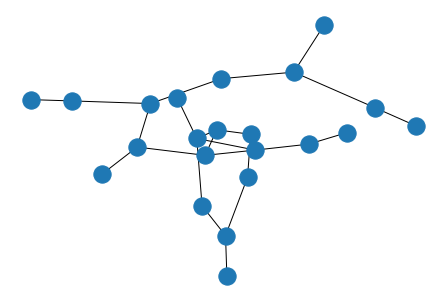

In [201]:
nx.draw(predicted_graphs_x[105], cmap = plt.get_cmap('jet'))
plt.show()

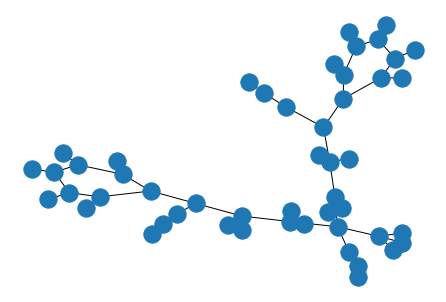

In [144]:
nx.draw(graphs[16], cmap = plt.get_cmap('jet'))
plt.show()